# BENG0095 Project

## Introduction [CHANGE]

In this notebook we will explore various binary classification algortihms, including Linear Discriminant Analysis (LDA), Quadratic Discriminant Analysis (QDA), Logistic Regression, and Naive Bayes. 

We will apply these algorithms to one toy data set, and two real-world datasets: the Pima Indians Diabetes data set; and the Wisconsin Diagnostic Breast Cancer data set. 

We will evaluate performances using three metrics: Classifcation Accuracy, the Receiver Operating Characteristic, and Precision/Recall scores.

## Imports

We start by importing all relevant packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from statistics import mean, stdev

from os import chdir
from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, roc_curve, precision_recall_curve, classification_report, ConfusionMatrixDisplay, auc

# Part 1 - Data cleaning

The first step is making sure the imported data is relevant and has no issues that could affect model performance.

## Training data - International match history dataset

The International Match History Dataset compiles football match results of between national teams between 2004-09-03 and 2021-12-18.

The dataset contains data from 5,641 matches with 25 features:

1. Date
2. Home team (HT)
3. Away team (AT)
4. HT continent
5. AT continent
6. HT FIFA rank
7. AT FIFA rank
8. HT total FIFA points
9. AT total FIFA points
10. HT score
11. AT score
12. Tournament
13. City
14. Country
15. Neutral location
16. Shoot out
17. HT result
18. HT goalkeeper score
19. AT goalkeeper score
20. HT defense score
21. HT offense score
22. HT midfield score
23. AT defense score
24. AT offense score
25. AT midfield score

### Loading the dataset

We first load the dataset and visualise it to understand it better

In [2]:
# changing directory to current working directory
import os 
chdir(os.getcwd())

# reading raw .csv file
data = pd.read_csv('dataset/match_history.csv')

# date is imported as string, we change to datetime for easier cleaning
data['date'] = pd.to_datetime(data['date']).dt.date

In [3]:
# visualising first 5 rows
data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,0,0,1,...,No,Draw,94.0,84.0,86.5,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,2,...,No,Win,NaN,90.0,NaN,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,2,...,No,Draw,83.0,88.0,76.2,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,3,...,No,Win,77.0,74.0,80.5,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,1,...,No,Draw,82.0,NaN,79.5,85.0,81.5,NaN,81.7,65.8


### Plotting correlations

In order to understand better the numerical data before processing it, we want to see if any variables are particularly correlated.

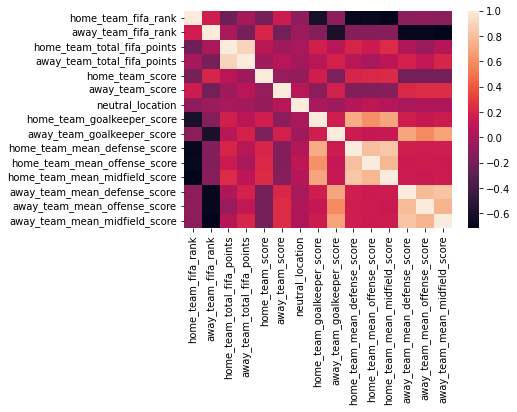

In [4]:
# compute correlations between features
corr = data.corr()

from seaborn import heatmap
heatmap(corr)

plt.show()

### _Takeaways_

1. Scores of different positions within the same team and same match are highly positively correlated.
2. Team FIFA rank and positions' scores are highly negatively correlated.

### Plotting features - Histogram

To understand data further, we plot histograms of all numerical features.

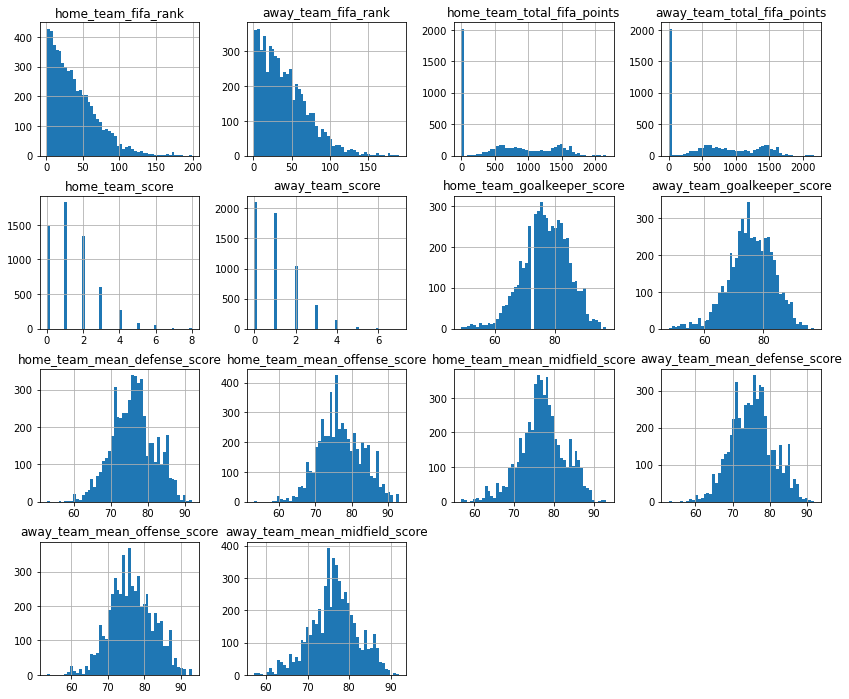

In [5]:
data.hist(bins=50, figsize=(14, 12))
plt.show()

### _Takeaways_

1. FIFA points columns (_home_team_total_fifa_points_ and _away_team_total_fifa_points_) have a large number of zeroes, which seems like a problem with the data and needs to be investigated further.
2. _home_team_goalkeeper_score_ seems to have a gap at around 72.
3. Most other data roughly follows normal distributions.

### Probing FIFA points

In order to clean the data, we first need to understand why there are large numbers of zero values in the FIFA points columns.

In [6]:
# select all rows where home team fifa points is zero
zero_points = data.query('home_team_total_fifa_points == 0')
zero_points.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,0,0,1,...,No,Draw,94.0,84.0,86.5,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,2,...,No,Win,NaN,90.0,NaN,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,2,...,No,Draw,83.0,88.0,76.2,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,3,...,No,Win,77.0,74.0,80.5,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,1,...,No,Draw,82.0,NaN,79.5,85.0,81.5,NaN,81.7,65.8


In [7]:
# printing them in descending order by date
zero_points.sort_values(by = 'date', ascending=False).head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
2016,2011-08-10,Wales,Australia,Europe,Oceania,112,22,0,0,1,...,No,Lose,75.0,80.0,74.2,71.0,80.2,72.5,76.7,71.0
2001,2011-08-10,Israel,Côte d'Ivoire,Europe,Africa,32,15,0,0,3,...,No,Lose,78.0,72.0,67.0,69.0,73.8,75.8,83.3,77.2
1989,2011-08-10,Austria,Slovakia,Europe,Europe,66,29,0,0,1,...,No,Lose,75.0,72.0,74.0,74.0,74.8,74.8,77.3,74.2
1990,2011-08-10,Belarus,Bulgaria,Europe,Europe,42,48,0,0,1,...,No,Win,75.0,77.0,63.0,71.0,72.2,71.2,75.3,75.0
1991,2011-08-10,Bosnia and Herzegovina,Greece,Europe,Europe,41,13,0,0,0,...,No,Draw,76.0,74.0,72.5,78.3,77.5,75.5,76.3,75.5


Interesting... All zero values seem to be between the dates of 2004-09-03 and 2011-08-10.

We need to make sure that all values between these dates are zero.

In [8]:
# printing all values not equal to zero and lower than the upper boundary (home team)
nonzero_points = data.query('home_team_total_fifa_points != 0')
nonzero_points[nonzero_points['date'] <= dt.date(2011, 8, 10)]

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score


In [9]:
# printing all values not equal to zero and lower than the upper boundary (away team)
nonzero_points = data.query('away_team_total_fifa_points != 0')
nonzero_points[nonzero_points['date'] <= dt.date(2011, 8, 10)]

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score


We found something! It seems like the dataset is missing values for the fifa points before 2011-08-10, this will need to be cleaned up

### Data Cleansing

Now that we understand the data better, it is time to clean it up before training the model.

### Position scores

From printing the first few values of the data, we also realised there were some null (or NaN) values at in the columns displaying the scores of the different positions (home team defense, away team goalkeeper, etc).

Nonetheless, as seen in the correlations diagram, there is a strong correlation between one position's score and the score of the other positions (within the same match). Therefore, we have chosen to fill in the NaN values with the average of the other positions within the team each match.

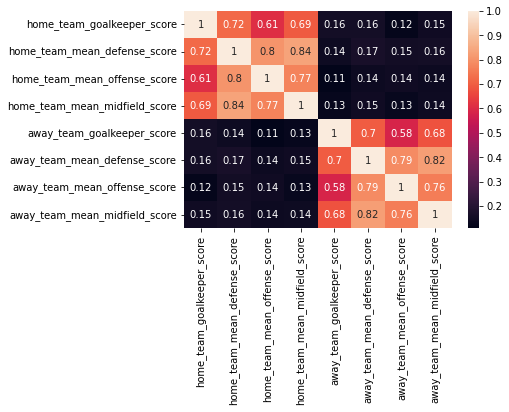

In [10]:
# compute correlations between team points
corr = data[['home_team_goalkeeper_score', \
             'home_team_mean_defense_score', \
             'home_team_mean_offense_score',\
             'home_team_mean_midfield_score', \
             'away_team_goalkeeper_score', \
             'away_team_mean_defense_score', \
             'away_team_mean_offense_score', \
             'away_team_mean_midfield_score']].corr()

heatmap(corr, annot=True)

plt.show()

In [11]:
# remember NaN values are ignored when calculating the average
home_mean = data[['home_team_goalkeeper_score', \
                  'home_team_mean_defense_score', \
                  'home_team_mean_offense_score',\
                  'home_team_mean_midfield_score']].mean(axis=1)

home_mean.head()

0    89.825
1    66.750
2    76.550
3    78.800
4    82.000
dtype: float64

In [12]:
clean_data = data
for i, col in enumerate(clean_data):
    clean_data.iloc[:, i] = data.iloc[:, i].fillna(home_mean)
    
clean_data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,0,0,1,...,No,Draw,94.00,84.0,86.50,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,2,...,No,Win,66.75,90.0,66.75,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,2,...,No,Draw,83.00,88.0,76.20,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,3,...,No,Win,77.00,74.0,80.50,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,1,...,No,Draw,82.00,82.0,79.50,85.0,81.5,82.0,81.7,65.8


In [13]:
# checking if there are any remaining NaN values
data_nan = clean_data[clean_data.isna().any(axis=1)]
data_nan.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score


Perfect! As we can see we have been able to replace all NaN values in the position scores section with the averages of the teams' scores.

### FIFA points cleanup

Given the values equal to zero in the FIFA points columns, we want to understand better how to get clean them.

In [14]:
# indentifying the data with FIFA points
mask = clean_data['date'] > dt.date(2011, 8, 10)
data_post2011 = clean_data.loc[mask]

data_post2011.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
2017,2011-08-27,Angola,Congo DR,Africa,Africa,96,127,338,221,1,...,No,Lose,70.0,67.066667,67.066667,69.7,61.5,69.2,69.7,70.0
2018,2011-09-02,Albania,France,Europe,Europe,57,15,546,918,1,...,No,Lose,70.0,86.000000,70.400000,69.7,71.5,82.5,83.0,84.5
2019,2011-09-02,Argentina,Venezuela,South America,South America,9,44,1016,615,1,...,No,Win,77.0,64.000000,80.800000,88.3,85.2,72.2,73.7,75.5
2020,2011-09-02,Belarus,Bosnia and Herzegovina,Europe,Europe,41,39,645,655,0,...,No,Lose,75.0,76.000000,63.200000,67.3,68.0,72.0,77.7,78.0
2021,2011-09-02,Bulgaria,England,Europe,Europe,51,4,585,1176,0,...,No,Lose,80.0,83.000000,70.800000,73.7,73.5,84.0,81.3,85.8


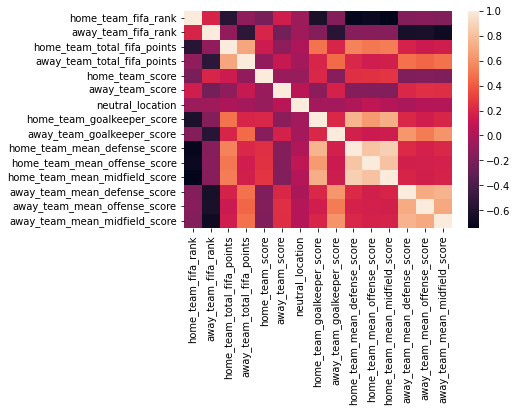

In [15]:
corr = data_post2011.corr()

heatmap(corr)

plt.show()

Interesting... it seems like there are some higher correlations between FIFA rank and FIFA points when data is nonzero.

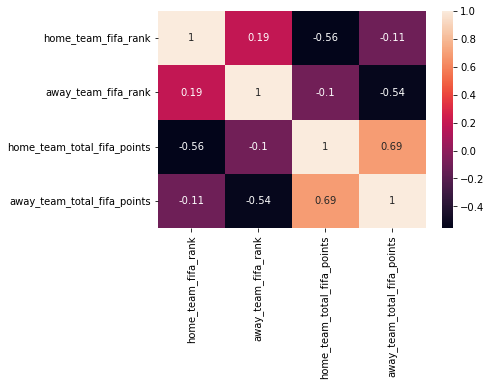

In [16]:
# compute correlations between features
corr = data_post2011[['home_team_fifa_rank', \
                      'away_team_fifa_rank', \
                      'home_team_total_fifa_points', \
                      'away_team_total_fifa_points']].corr()

heatmap(corr, annot=True)

plt.show()

Given the high correlation between FIFA rank and FIFA points, it seems like we can drop the FIFA points column with little impact on the performance of the model.

In [17]:
clean_data = clean_data.drop(columns=['home_team_total_fifa_points','away_team_total_fifa_points'])
clean_data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_score,away_team_score,tournament,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,1,1,Friendly,...,No,Draw,94.00,84.0,86.50,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,2,1,FIFA World Cup qualification,...,No,Win,66.75,90.0,66.75,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,2,2,FIFA World Cup qualification,...,No,Draw,83.00,88.0,76.20,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,3,0,FIFA World Cup qualification,...,No,Win,77.00,74.0,80.50,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,1,1,FIFA World Cup qualification,...,No,Draw,82.00,82.0,79.50,85.0,81.5,82.0,81.7,65.8


### Other cleanup

In order to feed the model the right data, we clean up further by dropping the date, continents, tournament, city, country and neutral location.

In [18]:
# Continents
clean_data['home_team_continent'].unique()

array(['Europe', 'Africa', 'South America', 'North America', 'Oceania',
       'Asia'], dtype=object)

In [19]:
# encoding string features as integers
le = LabelEncoder()

clean_data['home_team_continent'] = le.fit_transform(clean_data['home_team_continent'])
clean_data['away_team_continent'] = le.fit_transform(clean_data['away_team_continent'])

clean_data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_score,away_team_score,tournament,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,2,2,3,67,1,1,Friendly,...,No,Draw,94.00,84.0,86.50,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,2,2,94,14,2,1,FIFA World Cup qualification,...,No,Win,66.75,90.0,66.75,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,2,2,90,7,2,2,FIFA World Cup qualification,...,No,Draw,83.00,88.0,76.20,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,2,2,25,76,3,0,FIFA World Cup qualification,...,No,Win,77.00,74.0,80.50,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,2,2,15,87,1,1,FIFA World Cup qualification,...,No,Draw,82.00,82.0,79.50,85.0,81.5,82.0,81.7,65.8


In [20]:
# Tournament
clean_data['tournament'].unique()

array(['Friendly', 'FIFA World Cup qualification', "King's Cup",
       'CFU Caribbean Cup', 'Confederations Cup', 'Gold Cup',
       'EAFF Championship', 'African Cup of Nations',
       'Lunar New Year Cup', 'Cyprus International Tournament',
       'Kirin Cup', 'FIFA World Cup', 'UEFA Euro qualification',
       'African Cup of Nations qualification', 'Copa del Pacífico',
       'Copa América', 'AFC Asian Cup', 'UEFA Euro', 'COSAFA Cup',
       'Baltic Cup', 'UNCAF Cup', 'Nations Cup', 'Copa Confraternidad',
       'Superclásico de las Américas', 'Nehru Cup',
       'African Nations Championship', 'Kirin Challenge Cup', 'OSN Cup',
       'CFU Caribbean Cup qualification', 'Intercontinental Cup',
       'UEFA Nations League',
       'African Nations Championship qualification',
       'CONCACAF Nations League', 'Arab Cup'], dtype=object)

In [21]:
clean_data['tournament'] = (clean_data['tournament'] == 'Friendly').astype(int) # 1 Friendly 0 Else

In [22]:
# Drop city and country
clean_data = clean_data.drop(columns=['city', 'country'])

In [23]:
# Neutral location
clean_data['neutral_location'].unique()

array([False,  True])

In [24]:
clean_data['neutral_location'] = clean_data['neutral_location'].map({True:1, False:0})

In [25]:
# Shoot out
clean_data['shoot_out'].unique()

array(['No', 'Yes'], dtype=object)

In [26]:
# if shoot out then equivalent to Draw in world cup group stage
clean_data['home_team_result'] = np.where(clean_data['shoot_out']=='Yes', 'Draw', clean_data['home_team_result'])
clean_data = clean_data.drop(columns=['shoot_out'])

In [27]:
# Home team result
clean_data['home_team_result'].unique()

array(['Draw', 'Win', 'Lose'], dtype=object)

In [28]:
clean_data['home_team_result'] = clean_data['home_team_result'].map({'Win':1, 'Draw':0, 'Lose':-1})

In [29]:
clean_data = clean_data.drop(columns=['home_team_score','away_team_score'])

In [30]:
clean_data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,tournament,neutral_location,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,2,2,3,67,1,0,0,94.00,84.0,86.50,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,2,2,94,14,0,0,1,66.75,90.0,66.75,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,2,2,90,7,0,0,0,83.00,88.0,76.20,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,2,2,25,76,0,0,1,77.00,74.0,80.50,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,2,2,15,87,0,0,0,82.00,82.0,79.50,85.0,81.5,82.0,81.7,65.8


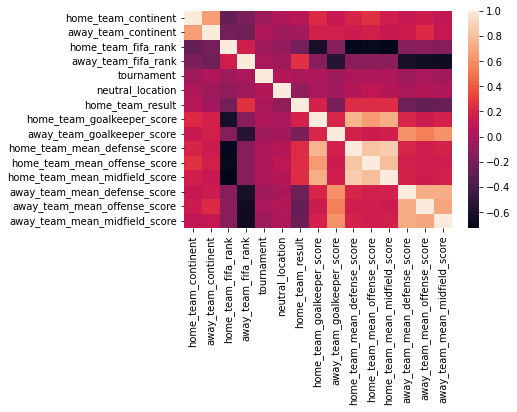

In [31]:
corr = clean_data.corr()

heatmap(corr)

plt.show()

In [32]:
clean_data = clean_data.drop(columns=['home_team_continent','away_team_continent'])

In [33]:
# copy final clean data with date for later use, remove for algorithms
date_data = clean_data
clean_data2 = clean_data # used for feature engineering
clean_data = clean_data.drop(columns=['date'])

In [34]:
# encode home and away teams as ints
le.fit(clean_data['away_team'])

clean_data['home_team'] = le.transform(clean_data['home_team'])
clean_data['away_team'] = le.transform(clean_data['away_team'])

clean_data.head()

,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,tournament,neutral_location,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,96,89,3,67,1,0,0,94.00,84.0,86.50,89.3,89.5,80.2,79.7,81.8
1,0,45,94,14,0,0,1,66.75,90.0,66.75,59.0,74.5,82.8,83.7,85.2
2,6,36,90,7,0,0,0,83.00,88.0,76.20,73.0,74.0,90.5,88.7,91.2
3,28,50,25,76,0,0,1,77.00,74.0,80.50,78.7,79.0,71.8,75.7,70.2
4,33,106,15,87,0,0,0,82.00,82.0,79.50,85.0,81.5,82.0,81.7,65.8


In [35]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5641 entries, 0 to 5640
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   home_team                      5641 non-null   int64  
 1   away_team                      5641 non-null   int64  
 2   home_team_fifa_rank            5641 non-null   int64  
 3   away_team_fifa_rank            5641 non-null   int64  
 4   tournament                     5641 non-null   int64  
 5   neutral_location               5641 non-null   int64  
 6   home_team_result               5641 non-null   int64  
 7   home_team_goalkeeper_score     5641 non-null   float64
 8   away_team_goalkeeper_score     5641 non-null   float64
 9   home_team_mean_defense_score   5641 non-null   float64
 10  home_team_mean_offense_score   5641 non-null   float64
 11  home_team_mean_midfield_score  5641 non-null   float64
 12  away_team_mean_defense_score   5641 non-null   f

# Part 2 - Feature engineering

Now that the training data is clean, we want to adapt the test and prediction data so that the performance of the model can be assessed.

The main issue is that the datasets for testing (`test_set.csv`) and predicting (`woldcup_2022.csv`) do not have all the required features. Therefore, we need to engineer them in a way that is accurate enough for the model to have good results.

## Test data
For the test data, we import external data to fill in many of the features missing. However, this is not sufficient given that we do not have data for the positions' scores. Hence, we also created a prediction tool to extrapolate the positions scores for each match given the change in the team's performance for the past 3 years. 

[NICCO CHECKKKK]

In [36]:
# reading raw .csv file
pred_data = pd.read_csv('dataset/worldcup_2022.csv')

# date is imported as string, we change to datetime for easier cleaning
pred_data['date'] = pd.to_datetime(pred_data['date']).dt.date

# save a copy to print output
pred_output = pred_data

pred_data.tail()

,date,home_team,away_team
43,2022-12-01,Costa Rica,Germany
44,2022-12-02,Ghana,Uruguay
45,2022-12-02,Korea Republic,Portugal
46,2022-12-02,Serbia,Switzerland
47,2022-12-02,Cameroon,Brazil


In [37]:
# filling in tournament and neutral location features
pred_data = pred_data.assign(tournament=np.zeros(48, dtype=int))

# Qatar plays in indices 0 and 35
nloc = np.full(48, 1)
nloc[0], nloc[35] = 0, 0
pred_data = pred_data.assign(neutral_location=nloc)

pred_data.head()

,date,home_team,away_team,tournament,neutral_location
0,2022-11-20,Qatar,Ecuador,0,0
1,2022-11-21,Senegal,Netherlands,0,1
2,2022-11-21,England,IR Iran,0,1
3,2022-11-21,USA,Wales,0,1
4,2022-11-22,France,Australia,0,1


In [38]:
# initialise remaining features
pred_data = pred_data.assign(home_team_fifa_rank=np.zeros(48, dtype=int))
pred_data = pred_data.assign(away_team_fifa_rank=np.zeros(48, dtype=int))
pred_data = pred_data.assign(home_team_goalkeeper_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(away_team_goalkeeper_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(home_team_mean_defense_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(home_team_mean_offense_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(home_team_mean_midfield_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(away_team_mean_defense_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(away_team_mean_offense_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(away_team_mean_midfield_score=np.zeros(48, dtype=float))

pred_data.head()

,date,home_team,away_team,tournament,neutral_location,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2022-11-20,Qatar,Ecuador,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-11-21,Senegal,Netherlands,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-11-21,England,IR Iran,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-11-21,USA,Wales,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-11-22,France,Australia,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# finding all countries that play in the world cup
countries_22 = np.unique(pred_data[['home_team', 'away_team']].values)
countries_22

array(['Argentina', 'Australia', 'Belgium', 'Brazil', 'Cameroon',
       'Canada', 'Costa Rica', 'Croatia', 'Denmark', 'Ecuador', 'England',
       'France', 'Germany', 'Ghana', 'IR Iran', 'Japan', 'Korea Republic',
       'Mexico', 'Morocco', 'Netherlands', 'Poland', 'Portugal', 'Qatar',
       'Saudi Arabia', 'Senegal', 'Serbia', 'Spain', 'Switzerland',
       'Tunisia', 'USA', 'Uruguay', 'Wales'], dtype=object)

In [40]:
# function to update missing prediction data with last match outcomes
def update_pred_data(country):
    last_home = clean_data2.query("home_team == @country").tail(1)
    last_away = clean_data2.query("away_team == @country").tail(1)
    
    if last_home['date'].item() > last_away['date'].item():

        pred_data['home_team_fifa_rank'] = np.where(pred_data['home_team'] == country, \
                                                    last_home['home_team_fifa_rank'].item(), \
                                                    pred_data['home_team_fifa_rank'])
        pred_data['home_team_goalkeeper_score'] = np.where(pred_data['home_team'] == country, \
                                                           last_home['home_team_goalkeeper_score'].item(), \
                                                           pred_data['home_team_goalkeeper_score'])
        pred_data['home_team_mean_defense_score'] = np.where(pred_data['home_team'] == country, \
                                                             last_home['home_team_mean_defense_score'].item(), \
                                                             pred_data['home_team_mean_defense_score'])
        pred_data['home_team_mean_offense_score'] = np.where(pred_data['home_team'] == country, \
                                                             last_home['home_team_mean_offense_score'].item(), \
                                                             pred_data['home_team_mean_offense_score'])
        pred_data['home_team_mean_midfield_score'] = np.where(pred_data['home_team'] == country, \
                                                              last_home['home_team_mean_midfield_score'].item(), \
                                                              pred_data['home_team_mean_midfield_score'])

        pred_data['away_team_fifa_rank'] = np.where(pred_data['away_team'] == country, \
                                                    last_home['home_team_fifa_rank'].item(), \
                                                    pred_data['away_team_fifa_rank'])
        pred_data['away_team_goalkeeper_score'] = np.where(pred_data['away_team'] == country, \
                                                           last_home['home_team_goalkeeper_score'].item(), \
                                                           pred_data['away_team_goalkeeper_score'])
        pred_data['away_team_mean_defense_score'] = np.where(pred_data['away_team'] == country, \
                                                             last_home['home_team_mean_defense_score'].item(), \
                                                             pred_data['away_team_mean_defense_score'])
        pred_data['away_team_mean_offense_score'] = np.where(pred_data['away_team'] == country, \
                                                             last_home['home_team_mean_offense_score'].item(), \
                                                             pred_data['away_team_mean_offense_score'])
        pred_data['away_team_mean_midfield_score'] = np.where(pred_data['away_team'] == country, \
                                                              last_home['home_team_mean_midfield_score'].item(), \
                                                              pred_data['away_team_mean_midfield_score'])
        
    else:
        pred_data['home_team_fifa_rank'] = np.where(pred_data['home_team'] == country, \
                                                    last_away['away_team_fifa_rank'].item(), \
                                                    pred_data['home_team_fifa_rank'])
        pred_data['home_team_goalkeeper_score'] = np.where(pred_data['home_team'] == country, \
                                                           last_away['away_team_goalkeeper_score'].item(), \
                                                           pred_data['home_team_goalkeeper_score'])
        pred_data['home_team_mean_defense_score'] = np.where(pred_data['home_team'] == country, \
                                                             last_away['away_team_mean_defense_score'].item(), \
                                                             pred_data['home_team_mean_defense_score'])
        pred_data['home_team_mean_offense_score'] = np.where(pred_data['home_team'] == country, \
                                                             last_away['away_team_mean_offense_score'].item(), \
                                                             pred_data['home_team_mean_offense_score'])
        pred_data['home_team_mean_midfield_score'] = np.where(pred_data['home_team'] == country, \
                                                              last_away['away_team_mean_midfield_score'].item(), \
                                                              pred_data['home_team_mean_midfield_score'])

        pred_data['away_team_fifa_rank'] = np.where(pred_data['away_team'] == country, \
                                                    last_away['away_team_fifa_rank'].item(), \
                                                    pred_data['away_team_fifa_rank'])
        pred_data['away_team_goalkeeper_score'] = np.where(pred_data['away_team'] == country, \
                                                           last_away['away_team_goalkeeper_score'].item(), \
                                                           pred_data['away_team_goalkeeper_score'])
        pred_data['away_team_mean_defense_score'] = np.where(pred_data['away_team'] == country, \
                                                             last_away['away_team_mean_defense_score'].item(), \
                                                             pred_data['away_team_mean_defense_score'])
        pred_data['away_team_mean_offense_score'] = np.where(pred_data['away_team'] == country, \
                                                             last_away['away_team_mean_offense_score'].item(), \
                                                             pred_data['away_team_mean_offense_score'])
        pred_data['away_team_mean_midfield_score'] = np.where(pred_data['away_team'] == country, \
                                                              last_away['away_team_mean_midfield_score'].item(), \
                                                              pred_data['away_team_mean_midfield_score'])

In [41]:
# loop through all countries to update prediction data
for i in countries_22:
    if i != 'Qatar':
        update_pred_data(i)

In [42]:
pred_data1 = pred_data # Used later for filling missing scores
pred_data.head()

,date,home_team,away_team,tournament,neutral_location,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2022-11-20,Qatar,Ecuador,0,0,0,55,0.0,71.0,0.0,0.0,0.0,73.5,76.0,74.5
1,2022-11-21,Senegal,Netherlands,0,1,20,11,83.0,81.0,79.0,80.7,79.0,85.2,83.0,83.5
2,2022-11-21,England,IR Iran,0,1,5,22,83.0,73.0,85.0,88.0,84.0,69.0,75.3,69.0
3,2022-11-21,USA,Wales,0,1,12,19,77.0,74.0,75.8,77.7,75.8,75.0,73.0,78.5
4,2022-11-22,France,Australia,0,1,3,34,87.0,77.0,84.2,88.3,86.8,72.0,72.3,73.5


In [43]:
# drop date for model
pred_data = pred_data.drop(columns=['date'])

In [44]:
# convert team names into dummy/indicator variables
pred_data = pd.get_dummies(pred_data)

In [45]:
# find missing features
clean_cols = list(clean_data.columns)
pred_cols = list(pred_data.columns)

missing = [i for i in clean_cols + pred_cols if i not in clean_cols or i not in pred_cols]
missing.remove('home_team_result')

In [46]:
for i in missing:
    pred_data[i] = np.zeros(48, dtype=int)

In [47]:
### NICCO BREAK START ###

In [48]:
# Create a var containing rows regarding Argentina only
team = 'Argentina'
argentina_data_tot = clean_data2.loc[((clean_data2['home_team'] == team) | (clean_data2['away_team'] == team))]

argentina_data_tot.tail()

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,tournament,neutral_location,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
5516,2021-10-07,Paraguay,Argentina,35,6,0,0,0,72.0,84.0,74.2,74.3,76.2,82.2,89.0,84.0
5543,2021-10-10,Argentina,Uruguay,6,12,0,0,1,84.0,80.0,82.2,89.0,84.0,81.2,84.3,80.0
5570,2021-10-14,Argentina,Peru,6,21,0,0,1,84.0,74.0,82.2,89.0,84.0,74.5,73.0,76.8
5597,2021-11-12,Uruguay,Argentina,15,6,0,0,-1,80.0,84.0,81.2,84.3,80.0,82.2,89.0,84.0
5632,2021-11-16,Argentina,Brazil,6,2,0,0,0,84.0,89.0,82.2,89.0,84.0,84.8,86.3,85.5


In [49]:
# Add column for categorising if Argentina is accounted as home or away team
argentina_data_tot['is_home'] = argentina_data_tot['home_team'].map({team:1}, na_action='ignore')
argentina_data_tot['is_home'] = argentina_data_tot['is_home'].replace(np.nan, 0)

argentina_data_tot.head()

/var/folders/f4/790bcdts1jg40nty042y1_1m0000gn/T/ipykernel_75192/3912014453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  argentina_data_tot['is_home'] = argentina_data_tot['home_team'].map({team:1}, na_action='ignore')
/var/folders/f4/790bcdts1jg40nty042y1_1m0000gn/T/ipykernel_75192/3912014453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  argentina_data_tot['is_home'] = argentina_data_tot['is_home'].replace(np.nan, 0)


,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,tournament,neutral_location,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score,is_home
9,2004-09-04,Peru,Argentina,63,4,0,0,-1,53.0,78.0,63.350000,73.7,63.35,87.0,87.0,88.5,0.0
29,2004-10-09,Argentina,Uruguay,3,17,0,0,1,78.0,74.0,87.000000,87.0,88.50,75.5,83.0,78.8,1.0
46,2004-10-13,Chile,Argentina,79,3,0,0,0,81.0,78.0,77.933333,79.3,73.50,87.0,87.0,88.5,0.0
84,2005-02-09,Germany,Argentina,16,3,1,0,0,94.0,78.0,87.500000,82.7,87.50,87.0,87.0,88.5,0.0
98,2005-03-09,Mexico,Argentina,6,3,1,1,0,78.0,78.0,76.000000,71.7,76.20,87.0,87.0,88.5,0.0


In [50]:
pd.options.mode.chained_assignment = None  # default='warn', avoids annoying warnings

# Build 2 separate DFs for argentina as home and away team, drop useless columns and rename columns with same names  
argentina_scores_home = argentina_data_tot.loc[argentina_data_tot['is_home'] == 1]

# Difference in scores between Argentina and team they played against (absolute values)
argentina_scores_home['rank_team_diff']       = argentina_scores_home['home_team_fifa_rank'].sub(argentina_scores_home['away_team_fifa_rank'], axis=0)
argentina_scores_home['goalkeeper_team_diff'] = argentina_scores_home['home_team_goalkeeper_score'].sub(argentina_scores_home['away_team_goalkeeper_score'], axis=0)
argentina_scores_home['defense_team_diff']    = argentina_scores_home['home_team_mean_defense_score'].sub(argentina_scores_home['away_team_mean_defense_score'], axis=0)
argentina_scores_home['offense_team_diff']    = argentina_scores_home['home_team_mean_offense_score'].sub(argentina_scores_home['away_team_mean_offense_score'], axis=0)
argentina_scores_home['midfield_team_diff']   = argentina_scores_home['home_team_mean_midfield_score'].sub(argentina_scores_home['away_team_mean_midfield_score'], axis=0)
argentina_scores_home['mean_team_diff']       = argentina_scores_home[['goalkeeper_team_diff', 'defense_team_diff', 'offense_team_diff', 'midfield_team_diff']].mean(axis=1)

# Drop useless columns
argentina_scores_home = argentina_scores_home.drop(columns=['home_team','away_team',
                                                            'away_team_fifa_rank',
                                                            'tournament',
                                                            'neutral_location',
                                                            'away_team_goalkeeper_score',
                                                            'away_team_mean_defense_score',
                                                            'away_team_mean_offense_score',
                                                            'away_team_mean_midfield_score',
                                                            'is_home'])
# Rename columns so that 2 DFs can be merged
argentina_scores_home = argentina_scores_home.rename(columns={'home_team_fifa_rank':'fifa_rank',
                                                              'home_team_result':'result',
                                                              'home_team_goalkeeper_score':'goalkeeper_score',
                                                              'home_team_mean_defense_score':'mean_defense_score',
                                                              'home_team_mean_offense_score':'mean_offense_score',
                                                              'home_team_mean_midfield_score':'mean_midfield_score'})

argentina_scores_away = argentina_data_tot.loc[argentina_data_tot['is_home'] == 0]

# Difference in scores between Argentina and team they played against (absolute values)
argentina_scores_away['rank_team_diff']       = argentina_scores_away['away_team_fifa_rank'].sub(argentina_scores_away['home_team_fifa_rank'], axis=0)
argentina_scores_away['goalkeeper_team_diff'] = argentina_scores_away['away_team_goalkeeper_score'].sub(argentina_scores_away['home_team_goalkeeper_score'], axis=0)
argentina_scores_away['defense_team_diff']    = argentina_scores_away['away_team_mean_defense_score'].sub(argentina_scores_away['home_team_mean_defense_score'], axis=0)
argentina_scores_away['offense_team_diff']    = argentina_scores_away['away_team_mean_offense_score'].sub(argentina_scores_away['home_team_mean_offense_score'], axis=0)
argentina_scores_away['midfield_team_diff']   = argentina_scores_away['away_team_mean_midfield_score'].sub(argentina_scores_away['home_team_mean_midfield_score'], axis=0)
argentina_scores_away['mean_team_diff']       = argentina_scores_away[['goalkeeper_team_diff', 'defense_team_diff', 'offense_team_diff', 'midfield_team_diff']].mean(axis=1)


argentina_scores_away = argentina_scores_away.drop(columns=['home_team',
                                                            'away_team',
                                                            'home_team_fifa_rank',
                                                            'tournament',
                                                            'neutral_location',
                                                            'home_team_goalkeeper_score',
                                                            'home_team_mean_defense_score',
                                                            'home_team_mean_offense_score',
                                                            'home_team_mean_midfield_score',
                                                            'is_home'])

argentina_scores_away = argentina_scores_away.rename(columns={'away_team_fifa_rank':'fifa_rank',
                                                              'home_team_result':'result',
                                                              'away_team_goalkeeper_score':'goalkeeper_score',
                                                              'away_team_mean_defense_score':'mean_defense_score',
                                                              'away_team_mean_offense_score':'mean_offense_score',
                                                              'away_team_mean_midfield_score':'mean_midfield_score'})

# Change scores for away DF to the same structure as home DF
argentina_scores_away['result'] = argentina_scores_away['result'].map({0:0, 1:-1, -1:1})    

In [51]:
argentina_scores = pd.concat([argentina_scores_home, argentina_scores_away]).sort_index() # Merge 2 DFs
argentina_scores['dummy'] = 0 # [CHANGE] Column needed for scatter plot later. There should be an alternative better way to do it
argentina_scores.reset_index(inplace=True, drop=True)
argentina_scores.head()

,date,fifa_rank,result,goalkeeper_score,mean_defense_score,mean_offense_score,mean_midfield_score,rank_team_diff,goalkeeper_team_diff,defense_team_diff,offense_team_diff,midfield_team_diff,mean_team_diff,dummy
0,2004-09-04,4,1,78.0,87.0,87.0,88.5,-59,25.0,23.650000,13.3,25.15,21.775000,0
1,2004-10-09,3,1,78.0,87.0,87.0,88.5,-14,4.0,11.500000,4.0,9.70,7.300000,0
2,2004-10-13,3,0,78.0,87.0,87.0,88.5,-76,-3.0,9.066667,7.7,15.00,7.191667,0
3,2005-02-09,3,0,78.0,87.0,87.0,88.5,-13,-16.0,-0.500000,4.3,1.00,-2.800000,0
4,2005-03-09,3,0,78.0,87.0,87.0,88.5,-3,0.0,11.000000,15.3,12.30,9.650000,0


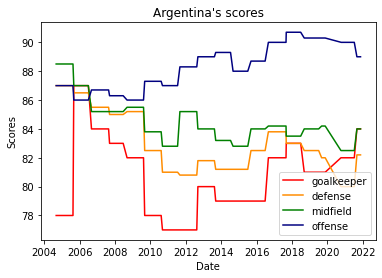

In [52]:
plt.figure()

plt.plot(argentina_scores['date'], 
         argentina_scores['goalkeeper_score'], 
         #color='tomato',
         color='red',
         label='goalkeeper')

plt.plot(argentina_scores['date'], 
         argentina_scores['mean_defense_score'], 
         #color='royalblue',
         color='darkorange',
         label='defense')

plt.plot(argentina_scores['date'], 
         argentina_scores['mean_midfield_score'], 
         #color='forestgreen',
         color='green',
         label='midfield')

plt.plot(argentina_scores['date'], 
         argentina_scores['mean_offense_score'], 
         #color='slategrey',
         color='navy',
         label='offense')

plt.xlabel('Date')
plt.ylabel('Scores')
plt.title("Argentina's scores")
plt.legend(loc='lower right')

plt.show()

[CHANGE]

So we can see that the curves for defens, goalkeeper and midfield scores decrease and increase pretty much at the same time. Computing the differentials will also be beneficial. All of the above can be looped for all the teams that we are interested in

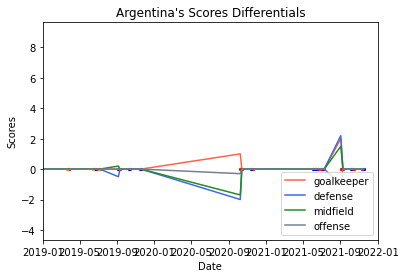

In [53]:
# Compute differentials
argentina_scores['rank_diff'] = argentina_scores['fifa_rank'].diff()
argentina_scores['goalkeeper_diff'] = argentina_scores['goalkeeper_score'].diff()
argentina_scores['defense_diff'] = argentina_scores['mean_defense_score'].diff()
argentina_scores['midfield_diff'] = argentina_scores['mean_midfield_score'].diff()
argentina_scores['offense_diff'] = argentina_scores['mean_offense_score'].diff()

plt.figure()
plt.plot(argentina_scores['date'], 
         argentina_scores['goalkeeper_diff'], 
         color='tomato',
         label='goalkeeper')
plt.plot(argentina_scores['date'], 
         argentina_scores['defense_diff'], 
         color='royalblue',
         label='defense')
plt.plot(argentina_scores['date'], 
         argentina_scores['midfield_diff'], 
         color='forestgreen',
         label='midfield')
plt.plot(argentina_scores['date'], 
         argentina_scores['offense_diff'], 
         color='slategrey',
         label='offense')
plt.xlabel('Date')
plt.ylabel('Scores')
plt.title("Argentina's Scores Differentials")
plt.legend(loc='lower right')

# [CHANGE] We need to find out how the spikes above are correlated with wins/losses/draws. 
# We can add a win/loss/draw on the chart to see it.

plt.scatter(x=argentina_scores['date'].loc[argentina_scores['result']==1],
            y=argentina_scores['dummy'].loc[argentina_scores['result']==1],
            color='red',
            s=5)

plt.scatter(x=argentina_scores['date'].loc[argentina_scores['result']==0],
            y=argentina_scores['dummy'].loc[argentina_scores['result']==0],
            color='blue',
            s=5)

plt.scatter(x=argentina_scores['date'].loc[argentina_scores['result']==-1],
            y=argentina_scores['dummy'].loc[argentina_scores['result']==-1],
            color='orange',
            s=5)

plt.xlim([dt.date(2019, 1, 1), dt.date(2022, 1, 1)])
plt.show()

Not much can be concluded as Data is very messy. 2 options can be explored further. 1st is to check data on smaller time frames to see whether there is something interesting where the big spikes in the graph below has happened. On the other hand, it might also be interesting to check whether any spike is correlated to a loss/draw to a weaker team or a win to a stronger team. Maybe Argentina is not ideal for this analyses since it is top ranked. Also, our model is likely to predict that a stronger team will win on a weaker team (if it works well), therefore if we find out that this is actually true, then we may have a problem

In [54]:
# Finding when wins over stronger teams or draws/losses against weaker teams took place
# 2 options: either with avg difference in team score or with difference in rank. OR potentialli both conditions

argentina_scores_deviation_negative = argentina_scores.loc[((argentina_scores['result'] == 0|-1) & (argentina_scores['mean_team_diff']>0))]
#argentina_scores_deviation_negative = argentina_scores.loc[((argentina_scores['result'] == 0|-1) & (argentina_scores['rank_diff']<0))]

argentina_scores_deviation_negative.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 13 to 175
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  22 non-null     object 
 1   fifa_rank             22 non-null     int64  
 2   result                22 non-null     int64  
 3   goalkeeper_score      22 non-null     float64
 4   mean_defense_score    22 non-null     float64
 5   mean_offense_score    22 non-null     float64
 6   mean_midfield_score   22 non-null     float64
 7   rank_team_diff        22 non-null     int64  
 8   goalkeeper_team_diff  22 non-null     float64
 9   defense_team_diff     22 non-null     float64
 10  offense_team_diff     22 non-null     float64
 11  midfield_team_diff    22 non-null     float64
 12  mean_team_diff        22 non-null     float64
 13  dummy                 22 non-null     int64  
 14  rank_diff             22 non-null     float64
 15  goalkeeper_diff       2

In [55]:
argentina_scores_deviation_positive = argentina_scores.loc[((argentina_scores['result'] == 1|0) & (argentina_scores['mean_team_diff']<0))]
#argentina_scores_deviation_positive = argentina_scores.loc[((argentina_scores['result'] == 1|0) & (argentina_scores['rank_diff']>0))]

argentina_scores_deviation_positive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 6 to 198
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  14 non-null     object 
 1   fifa_rank             14 non-null     int64  
 2   result                14 non-null     int64  
 3   goalkeeper_score      14 non-null     float64
 4   mean_defense_score    14 non-null     float64
 5   mean_offense_score    14 non-null     float64
 6   mean_midfield_score   14 non-null     float64
 7   rank_team_diff        14 non-null     int64  
 8   goalkeeper_team_diff  14 non-null     float64
 9   defense_team_diff     14 non-null     float64
 10  offense_team_diff     14 non-null     float64
 11  midfield_team_diff    14 non-null     float64
 12  mean_team_diff        14 non-null     float64
 13  dummy                 14 non-null     int64  
 14  rank_diff             14 non-null     float64
 15  goalkeeper_diff       14

Next step is plotting differentials between the matches located in the above dataframes.

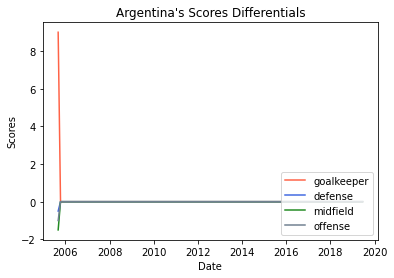

In [56]:
# Produce plots

plt.figure()
plt.plot(argentina_scores_deviation_negative['date'], 
         argentina_scores_deviation_negative['goalkeeper_diff'], 
         color='tomato',
         label='goalkeeper')
plt.plot(argentina_scores_deviation_negative['date'], 
         argentina_scores_deviation_negative['defense_diff'], 
         color='royalblue',
         label='defense')
plt.plot(argentina_scores_deviation_negative['date'], 
         argentina_scores_deviation_negative['midfield_diff'], 
         color='forestgreen',
         label='midfield')
plt.plot(argentina_scores_deviation_negative['date'], 
         argentina_scores_deviation_negative['offense_diff'], 
         color='slategrey',
         label='offense')
plt.xlabel('Date')
plt.ylabel('Scores')
plt.title("Argentina's Scores Differentials")
plt.legend(loc='lower right')
plt.show()

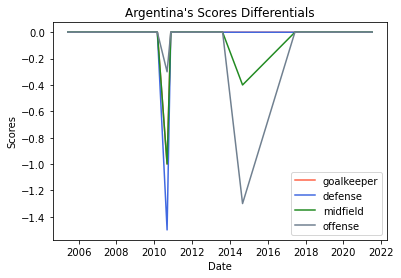

In [57]:
plt.figure()
plt.plot(argentina_scores_deviation_positive['date'], 
         argentina_scores_deviation_positive['goalkeeper_diff'], 
         color='tomato',
         label='goalkeeper')
plt.plot(argentina_scores_deviation_positive['date'], 
         argentina_scores_deviation_positive['defense_diff'], 
         color='royalblue',
         label='defense')
plt.plot(argentina_scores_deviation_positive['date'], 
         argentina_scores_deviation_positive['midfield_diff'], 
         color='forestgreen',
         label='midfield')
plt.plot(argentina_scores_deviation_positive['date'], 
         argentina_scores_deviation_positive['offense_diff'], 
         color='slategrey',
         label='offense')
plt.xlabel('Date')
plt.ylabel('Scores')
plt.title("Argentina's Scores Differentials")
plt.legend(loc='lower right')
plt.show()

2 observations: 1. Not all the spikes are highlighted. 2. Where I was expecting mainly positive variations I got negatives. So this is not the way.

Since no specific trend is found and big surges/drops in the scores are identified, it is sensible to fit to the following 6 months for engineering the test set the line of best fit, intended as the derivative. Since matches that are not recent are less relevant to the team performance in 2022, the derivative has been computed only over the last 2.5 years

In [58]:
ref_date = dt.date(2019, 1, 1)

argentina_scores.drop(argentina_scores[argentina_scores['date']<ref_date].index, inplace=True)

argentina_scores.head()

,date,fifa_rank,result,goalkeeper_score,mean_defense_score,mean_offense_score,mean_midfield_score,rank_team_diff,goalkeeper_team_diff,defense_team_diff,offense_team_diff,midfield_team_diff,mean_team_diff,dummy,rank_diff,goalkeeper_diff,defense_diff,midfield_diff,offense_diff
173,2019-03-22,11,-1,81.0,82.5,90.3,84.0,-21,8.0,8.3,13.0,8.8,9.525,0,-1.0,0.0,0.0,0.0,0.0
174,2019-03-26,11,1,81.0,82.5,90.3,84.0,-32,4.0,3.7,12.3,5.5,6.375,0,0.0,0.0,0.0,0.0,0.0
175,2019-06-15,11,-1,81.0,82.5,90.3,84.0,-2,3.0,2.3,8.0,1.8,3.775,0,0.0,0.0,0.0,0.0,0.0
176,2019-06-19,11,0,81.0,82.5,90.3,84.0,-25,4.0,6.5,13.6,6.5,7.650,0,0.0,0.0,0.0,0.0,0.0
177,2019-06-28,11,1,81.0,82.5,90.3,84.0,-22,8.0,8.3,13.0,8.8,9.525,0,0.0,0.0,0.0,0.0,0.0


Just for testing on 1 team, for easier coding.

In [59]:
derivative = pd.DataFrame()
date_diff = pd.DataFrame()

feature_list = ['fifa_rank','goalkeeper_score','mean_defense_score','mean_offense_score','mean_midfield_score']

score_diff = []
date_diff['date'] = argentina_scores['date'].diff(periods=(len(argentina_scores)-1)).reset_index(drop=True)
date_diff_num = date_diff.at[(len(argentina_scores)-1),'date']

for i in feature_list:
    derivative[i] = argentina_scores[i].diff(periods=(len(argentina_scores)-1)).reset_index(drop=True)
    j = derivative.at[(len(argentina_scores)-1),i]
    score_diff.append(j)

In [60]:
def team_score_derivative(team, ref_date):
    
    # Fetch all rows containing specific team
    team_data_tot = clean_data2.loc[((clean_data2['home_team'] == team) | (clean_data2['away_team'] == team))]
    
    
    team_data_tot.loc[:,('is_home')] = team_data_tot.loc[:,('home_team')].map({team:1}, na_action='ignore')
    team_data_tot.loc[:,('is_home')] = team_data_tot.loc[:,('is_home')].replace(np.nan, 0)
    
    # Build 2 separate DFs for argentina as home and away team, drop useless columns and rename columns with same names  
    team_scores_home = team_data_tot.loc[team_data_tot['is_home'] == 1]

    # Drop useless columns
    team_scores_home = team_scores_home.drop(columns=['home_team',
                                                      'away_team',
                                                      'away_team_fifa_rank',
                                                      'tournament',
                                                      'neutral_location',
                                                      'away_team_goalkeeper_score',
                                                      'away_team_mean_defense_score',
                                                      'away_team_mean_offense_score',
                                                      'away_team_mean_midfield_score',
                                                      'is_home'])
    # Rename columns so that 2 DFs can be merged
    team_scores_home = team_scores_home.rename(columns={'home_team_fifa_rank':'fifa_rank',
                                                        'home_team_result':'result',
                                                        'home_team_goalkeeper_score':'goalkeeper_score',
                                                        'home_team_mean_defense_score':'mean_defense_score',
                                                        'home_team_mean_offense_score':'mean_offense_score',
      
                                                        'home_team_mean_midfield_score':'mean_midfield_score'})
    # Do the same for Away DF
    team_scores_away = team_data_tot.loc[team_data_tot['is_home'] == 0]

    
    team_scores_away = team_scores_away.drop(columns=['home_team',
                                                      'away_team',
                                                      'home_team_fifa_rank',
                                                      'tournament',
                                                      'neutral_location',
                                                      'home_team_goalkeeper_score',
                                                      'home_team_mean_defense_score',
                                                      'home_team_mean_offense_score',
                                                      'home_team_mean_midfield_score',
                                                      'is_home'])

    team_scores_away = team_scores_away.rename(columns={'away_team_fifa_rank':'fifa_rank',
                                                        'home_team_result':'result',
                                                        'away_team_goalkeeper_score':'goalkeeper_score',
                                                        'away_team_mean_defense_score':'mean_defense_score',
                                                        'away_team_mean_offense_score':'mean_offense_score',
                                                        'away_team_mean_midfield_score':'mean_midfield_score'})

    # Change scores for away DF to the same structure as home DF
    team_scores_away['result'] = team_scores_away['result'].map({0:0, 1:-1, -1:1})
    
    # Merge DFs
    team_scores = pd.concat([team_scores_home, team_scores_away]).sort_index() # Merge 2 DFs
    team_scores.reset_index(inplace=True, drop=True)
    
    # Drop matches before reference date
    team_scores.drop(team_scores[team_scores['date']<ref_date].index, inplace=True)

    
    # Allocate variables for deriivatives computation
    derivative = pd.DataFrame()
    date_diff = pd.DataFrame()

    feature_list = np.array(['fifa_rank','goalkeeper_score','mean_defense_score','mean_offense_score','mean_midfield_score'])

    score_diff = np.array([])
    date_diff['date'] = team_scores['date'].diff(periods=(len(team_scores)-1)).reset_index(drop=True)
    if len(team_scores) != 0:
        date_diff_num = ([date_diff.at[(len(team_scores)-1),'date']])
    else: date_diff_num = None

    for i in feature_list:
        derivative[i] = team_scores[i].diff(periods=(len(team_scores)-1)).reset_index(drop=True)
        j = derivative.at[(len(team_scores)-1),i].round(2)
        score_diff = np.append(score_diff, j)

    return (score_diff, date_diff_num)
        

Iterate function over all teams.

In [61]:
ref_date = dt.date(2019, 1, 1)

score_diff_all_teams = np.array(['fifa_rank','goalkeeper_score','mean_defense_score','mean_offense_score','mean_midfield_score'])
date_diff_all_teams = np.array(['date'])

ind = np.argwhere(countries_22=='Qatar')
countries_22_clean = np.delete(countries_22, ind)   # drop Qatar

pd.options.mode.chained_assignment = None  # default='warn', avoids annoing warnings

for i in countries_22_clean:
    
    # print(i)
    score_diff_s, date_diff_num_s = team_score_derivative(i, ref_date)
    # print(score_diff_s, date_diff_num_s)
    # print(score_diff_s.shape)
    score_diff_all_teams = np.vstack([score_diff_all_teams,  score_diff_s])
    date_diff_all_teams = np.vstack([date_diff_all_teams, date_diff_num_s]) 

date_diff_all_teams_df = pd.DataFrame(date_diff_all_teams, columns=['deltas'])
date_diff_all_teams_df = date_diff_all_teams_df.iloc[1: , :]

date_diff_all_teams_df['days'] = (date_diff_all_teams_df['deltas'] / np.timedelta64(1, 'D')).astype(int)
date_diff_all_teams_df = date_diff_all_teams_df.drop(columns=['deltas'])
date_diff_all_teams_df.head()

,days
1,970
2,893
3,971
4,969
5,886


Here ends work on prediction set. From now, only test set.

Fetch all other features from big dataset (i.e., Shootout, Neutral Location)

In [62]:
# Load international matches dataset, only for 2022 onwards to avoid huge DF

international_matches = pd.read_csv('dataset/international_matches.csv')
international_matches['date'] = pd.to_datetime(international_matches['date']).dt.date

# loading test_set [2ND LOAD,CONSIDER WHICH ONE TO DELETE]
test_set = pd.read_csv('dataset/test_set.csv')
test_set['date'] = pd.to_datetime(test_set['date']).dt.date

In [63]:
# This has only the purpose of making the df lighter, as it is huge
ref_date = dt.date(2022, 1, 1)
international_matches.drop(international_matches[international_matches['date']<ref_date].index, inplace=True)

In [64]:
# Drop columns for scores, as we need to engineer them and using them is not admitted
international_matches = international_matches[['date','home_team','away_team','shoot_out','neutral_location','home_team_result','tournament']]
international_matches.head()

,date,home_team,away_team,shoot_out,neutral_location,home_team_result,tournament
23350,2022-01-02,Gabon,Burkina Faso,No,True,Lose,Friendly
23351,2022-01-02,Sudan,Zimbabwe,No,True,Draw,Friendly
23352,2022-01-03,Rwanda,Guinea,No,False,Win,Friendly
23353,2022-01-04,Mauritania,Gabon,No,True,Draw,Friendly
23354,2022-01-05,Algeria,Ghana,No,True,Win,Friendly


In [65]:
# merge 2 DFs according to test_set columns. RUN THIS ONLY ONCE, IF YOU WANT TO RUN AGAIN, REDEFINE TEST_SET FIRST
test_set = test_set.merge(international_matches, how='inner', on=['date','home_team','away_team','home_team_result'])
test_set

,date,home_team,away_team,home_team_result,shoot_out,neutral_location,tournament
0,2022-01-02,Gabon,Burkina Faso,Lose,No,True,Friendly
1,2022-01-05,Algeria,Ghana,Win,No,True,Friendly
2,2022-01-09,Cameroon,Burkina Faso,Win,No,False,African Cup of Nations
3,2022-01-10,Senegal,Zimbabwe,Win,No,True,African Cup of Nations
4,2022-01-10,Morocco,Ghana,Win,No,True,African Cup of Nations
...,...,...,...,...,...,...,...
242,2022-06-14,Bosnia and Herzegovina,Finland,Win,No,False,UEFA Nations League
243,2022-06-14,Romania,Montenegro,Lose,No,False,UEFA Nations League
244,2022-06-14,Chile,Ghana,Lose,Yes,True,Kirin Cup
245,2022-06-14,Japan,Tunisia,Lose,No,False,Kirin Cup


In [66]:
countries_test_set = np.unique(test_set[['home_team', 'away_team']].values)
countries_test_set

array(['Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Belgium', 'Benin', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burkina Faso',
       'Cabo Verde', 'Cameroon', 'Canada', 'Chile', 'China PR',
       'Colombia', 'Congo', 'Congo DR', 'Costa Rica', 'Croatia',
       'Curaçao', 'Cyprus', 'Czech Republic', "Côte d'Ivoire", 'Denmark',
       'Ecuador', 'Egypt', 'England', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guinea',
       'Guinea-Bissau', 'Honduras', 'Hungary', 'IR Iran', 'Iceland',
       'Israel', 'Italy', 'Jamaica', 'Japan', 'Korea Republic', 'Kosovo',
       'Luxembourg', 'Madagascar', 'Mali', 'Mexico', 'Montenegro',
       'Morocco', 'Netherlands', 'New Zealand', 'Nigeria',
       'North Macedonia', 'Northern Ireland', 'Norway', 'Panama',
       'Paraguay', 'Peru', 'Poland', 'Portugal', 'Republic of Ireland',
       'Romania', 'Saudi Arabia', 'Scotland', 'Senegal', '

In [67]:
# Initialise starting features
# initialise remaining features
test_set = test_set.assign(home_team_fifa_rank=np.zeros(len(test_set), dtype=int))
test_set = test_set.assign(away_team_fifa_rank=np.zeros(len(test_set), dtype=int))
test_set = test_set.assign(home_team_goalkeeper_score=np.zeros(len(test_set), dtype=float))
test_set = test_set.assign(away_team_goalkeeper_score=np.zeros(len(test_set), dtype=float))
test_set = test_set.assign(home_team_mean_defense_score=np.zeros(len(test_set), dtype=float))
test_set = test_set.assign(home_team_mean_offense_score=np.zeros(len(test_set), dtype=float))
test_set = test_set.assign(home_team_mean_midfield_score=np.zeros(len(test_set), dtype=float))
test_set = test_set.assign(away_team_mean_defense_score=np.zeros(len(test_set), dtype=float))
test_set = test_set.assign(away_team_mean_offense_score=np.zeros(len(test_set), dtype=float))
test_set = test_set.assign(away_team_mean_midfield_score=np.zeros(len(test_set), dtype=float))

test_set

,date,home_team,away_team,home_team_result,shoot_out,neutral_location,tournament,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2022-01-02,Gabon,Burkina Faso,Lose,No,True,Friendly,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-01-05,Algeria,Ghana,Win,No,True,Friendly,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-01-09,Cameroon,Burkina Faso,Win,No,False,African Cup of Nations,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-01-10,Senegal,Zimbabwe,Win,No,True,African Cup of Nations,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-01-10,Morocco,Ghana,Win,No,True,African Cup of Nations,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,2022-06-14,Bosnia and Herzegovina,Finland,Win,No,False,UEFA Nations League,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243,2022-06-14,Romania,Montenegro,Lose,No,False,UEFA Nations League,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,2022-06-14,Chile,Ghana,Lose,Yes,True,Kirin Cup,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245,2022-06-14,Japan,Tunisia,Lose,No,False,Kirin Cup,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
# function to update missing prediction data with last match outcomes
def update_test_data(country):
    last_home = date_data.query("home_team == @country").tail(1)
    last_away = date_data.query("away_team == @country").tail(1)
   
    
    if last_home['date'].item() > last_away['date'].item():

        test_set['home_team_fifa_rank'] = np.where(test_set['home_team'] == country, \
                                                    last_home['home_team_fifa_rank'].item(), \
                                                    test_set['home_team_fifa_rank'])
        test_set['home_team_goalkeeper_score'] = np.where(test_set['home_team'] == country, \
                                                           last_home['home_team_goalkeeper_score'].item(), \
                                                           test_set['home_team_goalkeeper_score'])
        test_set['home_team_mean_defense_score'] = np.where(test_set['home_team'] == country, \
                                                             last_home['home_team_mean_defense_score'].item(), \
                                                             test_set['home_team_mean_defense_score'])
        test_set['home_team_mean_offense_score'] = np.where(test_set['home_team'] == country, \
                                                             last_home['home_team_mean_offense_score'].item(), \
                                                             test_set['home_team_mean_offense_score'])
        test_set['home_team_mean_midfield_score'] = np.where(test_set['home_team'] == country, \
                                                              last_home['home_team_mean_midfield_score'].item(), \
                                                              test_set['home_team_mean_midfield_score'])

        test_set['away_team_fifa_rank'] = np.where(test_set['away_team'] == country, \
                                                    last_home['home_team_fifa_rank'].item(), \
                                                    test_set['away_team_fifa_rank'])
        test_set['away_team_goalkeeper_score'] = np.where(test_set['away_team'] == country, \
                                                           last_home['home_team_goalkeeper_score'].item(), \
                                                           test_set['away_team_goalkeeper_score'])
        test_set['away_team_mean_defense_score'] = np.where(test_set['away_team'] == country, \
                                                             last_home['home_team_mean_defense_score'].item(), \
                                                             test_set['away_team_mean_defense_score'])
        test_set['away_team_mean_offense_score'] = np.where(test_set['away_team'] == country, \
                                                             last_home['home_team_mean_offense_score'].item(), \
                                                             test_set['away_team_mean_offense_score'])
        test_set['away_team_mean_midfield_score'] = np.where(test_set['away_team'] == country, \
                                                              last_home['home_team_mean_midfield_score'].item(), \
                                                              test_set['away_team_mean_midfield_score'])
        
    else:
        test_set['home_team_fifa_rank'] = np.where(test_set['home_team'] == country, \
                                                    last_away['away_team_fifa_rank'].item(), \
                                                    test_set['home_team_fifa_rank'])
        test_set['home_team_goalkeeper_score'] = np.where(test_set['home_team'] == country, \
                                                           last_away['away_team_goalkeeper_score'].item(), \
                                                           test_set['home_team_goalkeeper_score'])
        test_set['home_team_mean_defense_score'] = np.where(test_set['home_team'] == country, \
                                                             last_away['away_team_mean_defense_score'].item(), \
                                                             test_set['home_team_mean_defense_score'])
        test_set['home_team_mean_offense_score'] = np.where(test_set['home_team'] == country, \
                                                             last_away['away_team_mean_offense_score'].item(), \
                                                             test_set['home_team_mean_offense_score'])
        test_set['home_team_mean_midfield_score'] = np.where(test_set['home_team'] == country, \
                                                              last_away['away_team_mean_midfield_score'].item(), \
                                                              test_set['home_team_mean_midfield_score'])

        test_set['away_team_fifa_rank'] = np.where(test_set['away_team'] == country, \
                                                    last_away['away_team_fifa_rank'].item(), \
                                                    test_set['away_team_fifa_rank'])
        test_set['away_team_goalkeeper_score'] = np.where(test_set['away_team'] == country, \
                                                           last_away['away_team_goalkeeper_score'].item(), \
                                                           test_set['away_team_goalkeeper_score'])
        test_set['away_team_mean_defense_score'] = np.where(test_set['away_team'] == country, \
                                                             last_away['away_team_mean_defense_score'].item(), \
                                                             test_set['away_team_mean_defense_score'])
        test_set['away_team_mean_offense_score'] = np.where(test_set['away_team'] == country, \
                                                             last_away['away_team_mean_offense_score'].item(), \
                                                             test_set['away_team_mean_offense_score'])
        test_set['away_team_mean_midfield_score'] = np.where(test_set['away_team'] == country, \
                                                              last_away['away_team_mean_midfield_score'].item(), \
                                                              test_set['away_team_mean_midfield_score'])


In [69]:
# Execute above function for all countries. DO NOT RUN TWICE
for i in countries_test_set:
    
    if i != 'Suriname':
        update_test_data(i)
        
test_set.to_csv('test_out_2.csv')

In [70]:
# Calculate differentials for countries in test_set
ref_date = dt.date(2019, 1, 1)

score_diff_all_teams = np.array(['fifa_rank','goalkeeper_score','mean_defense_score','mean_offense_score','mean_midfield_score'])
date_diff_all_teams = np.array(['date'])

pd.options.mode.chained_assignment = None  # default='warn', avoids annoing warnings

for i in countries_test_set:
    
    if i != 'Suriname':
               
        score_diff_s, date_diff_num_s = team_score_derivative(i, ref_date)

        score_diff_all_teams = np.vstack([score_diff_all_teams,  score_diff_s])
        date_diff_all_teams  = np.vstack([date_diff_all_teams, date_diff_num_s]) 

        
score_diff_all_teams_df = pd.DataFrame(score_diff_all_teams, columns=['fifa_rank',
                                                                      'goalkeeper_score',
                                                                      'mean_defense_score',
                                                                      'mean_offense_score',
                                                                      'mean_midfield_score']).round(2).iloc[1: , :].astype(float)

date_diff_all_teams_df = pd.DataFrame(date_diff_all_teams, columns=['deltas'])
date_diff_all_teams_df = date_diff_all_teams_df.iloc[1: , :]

date_diff_all_teams_df['days'] = (date_diff_all_teams_df['deltas'] / np.timedelta64(1, 'D')).astype(int)
date_diff_all_teams_df = date_diff_all_teams_df.drop(columns=['deltas'])

date_diff_all_teams_df

,days
1,966
2,998
3,644
4,970
5,967
...,...
87,252
88,893
89,970
90,972


To calculate the deltas, the dates of the first match for every team in test_set needs to be saved in an array.

In [71]:
first_date = np.array([])
for i in countries_test_set:
    team_set = test_set.loc[((test_set['home_team'] == i) | (test_set['away_team'] == i))]
    team_date = team_set['date'].head(1)
    first_date = np.append(first_date, team_date)

Now we need to add the derivative to all the scores filled in the test_set.

In [72]:
def update_scores_derivatives(country, j):

    #j: Counts teams, i.e. rows in score_diff_all_teams
    
    dates_home = pd.DataFrame([])
    dates_home['date'] = test_set['date'].loc[(test_set['home_team']==country)].reset_index(drop=True)
    dates_home['deltas'] = dates_home['date'].diff()
    dates_home = dates_home.iloc[1: , :]
    dates_home['days'] = (dates_home['deltas'] / np.timedelta64(1, 'D')).astype(int)
    dates_home = dates_home.drop(columns=['deltas','date'])
    
    if len(dates_home!=0):

        home_team_index = test_set.index[test_set['home_team']==country].tolist()
        
        date_diff_this_team = int(date_diff_all_teams_df.loc[j,'days'])

        for k in [home_team_index]:
            a = 1 # Counts progress in dates_home
            dates_home_s = int(dates_home.loc[a,'days'])

            test_set.loc[k,'home_team_fifa_rank']           = (test_set.loc[k,'home_team_fifa_rank'] + 
                                                               (score_diff_all_teams_df.iloc[j-1,0])*(dates_home_s/date_diff_this_team))
            test_set.loc[k,'home_team_goalkeeper_score']    = (test_set.loc[k,'home_team_goalkeeper_score'] + 
                                                               (score_diff_all_teams_df.iloc[j-1,1])*(dates_home_s/date_diff_this_team))
            test_set.loc[k,'home_team_mean_defense_score']  = (test_set.loc[k,'home_team_mean_defense_score'] + 
                                                               (score_diff_all_teams_df.iloc[j-1,2])*(dates_home_s/date_diff_this_team))
            test_set.loc[k,'home_team_mean_offense_score']  = (test_set.loc[k,'home_team_mean_offense_score'] + 
                                                               (score_diff_all_teams_df.iloc[j-1,3])*(dates_home_s/date_diff_this_team))
            test_set.loc[k,'home_team_mean_midfield_score'] = (test_set.loc[k,'home_team_mean_midfield_score'] + 
                                                               (score_diff_all_teams_df.iloc[j-1,4])*(dates_home_s/date_diff_this_team))
            a += 1
        else : None
    
    
    dates_away = pd.DataFrame([])
    dates_away['date'] = test_set['date'].loc[(test_set['away_team']==country)].reset_index(drop=True)
    dates_away['deltas'] = dates_away['date'].diff()
    dates_away = dates_away.iloc[1: , :]
    dates_away['days'] = (dates_away['deltas'] / np.timedelta64(1, 'D')).astype(int)
    dates_away = dates_away.drop(columns=['deltas','date'])
   
    if len(dates_away!=0):
        
        away_team_index = test_set.index[test_set['away_team']==country].tolist().pop(0)   
        date_diff_this_team = int(date_diff_all_teams_df.loc[j,'days']) # I think I can delete this line

        for k in [away_team_index]:
            a = 1 # Counts progress in dates_home
            dates_away_s = int(dates_away.loc[a,'days'])

            test_set.loc[k,'away_team_fifa_rank']     = (test_set.loc[k,'away_team_fifa_rank'] + 
                                                         (score_diff_all_teams_df.iloc[j-1,0])*(dates_away_s/date_diff_this_team))
            test_set.loc[k,'away_team_goalkeeper_score']    = (test_set.loc[k,'away_team_goalkeeper_score'] + 
                                                         (score_diff_all_teams_df.iloc[j-1,1])*(dates_away_s/date_diff_this_team))
            test_set.loc[k,'away_team_mean_defense_score']  = (test_set.loc[k,'away_team_mean_defense_score'] + 
                                                         (score_diff_all_teams_df.iloc[j-1,2])*(dates_away_s/date_diff_this_team))
            test_set.loc[k,'away_team_mean_offense_score']  = (test_set.loc[k,'away_team_mean_offense_score'] + 
                                                         (score_diff_all_teams_df.iloc[j-1,3])*(dates_away_s/date_diff_this_team))
            test_set.loc[k,'away_team_mean_midfield_score'] = (test_set.loc[k,'away_team_mean_midfield_score'] + 
                                                         (score_diff_all_teams_df.iloc[j-1,4])*(dates_away_s/date_diff_this_team))
            a += 1
    else: None
        

In [73]:
j = 1
for i in countries_test_set:
    
    if i != 'Suriname':
        
        update_scores_derivatives(i, j)
        j += 1
        
    else: None

# Save w/ different name to distinguish from pred 
test_data = test_set
test_data

,date,home_team,away_team,home_team_result,shoot_out,neutral_location,tournament,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2022-01-02,Gabon,Burkina Faso,Lose,No,True,Friendly,85.955224,61.023569,70.589254,73.054994,70.222388,70.205970,75.403731,69.503928,71.689787,66.972503
1,2022-01-05,Algeria,Ghana,Win,No,True,Friendly,28.922846,52.000000,78.914830,74.025853,78.066533,81.083166,77.767134,75.500000,75.989659,78.202068
2,2022-01-09,Cameroon,Burkina Faso,Win,No,False,African Cup of Nations,54.027088,61.000000,66.900677,73.000000,76.796388,77.688262,75.001806,69.500000,71.700000,67.000000
3,2022-01-10,Senegal,Zimbabwe,Win,No,True,African Cup of Nations,19.983402,118.000000,83.033195,70.875000,78.992531,80.698755,79.003320,65.000000,72.300000,70.875000
4,2022-01-10,Morocco,Ghana,Win,No,True,African Cup of Nations,26.819374,52.000000,82.393542,74.000000,81.388900,81.991221,76.018971,75.500000,76.000000,78.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,2022-06-14,Bosnia and Herzegovina,Finland,Win,No,False,UEFA Nations League,61.103896,60.000000,75.988012,83.000000,74.192008,76.993207,77.990010,70.000000,72.300000,73.500000
243,2022-06-14,Romania,Montenegro,Lose,No,False,UEFA Nations League,42.294606,73.000000,76.919087,65.000000,73.313900,73.651452,75.040456,76.200000,74.700000,68.200000
244,2022-06-14,Chile,Ghana,Lose,Yes,True,Kirin Cup,24.676411,52.000000,79.000000,74.000000,75.561492,76.497077,77.997077,75.500000,76.000000,78.200000
245,2022-06-14,Japan,Tunisia,Lose,No,False,Kirin Cup,25.879397,29.000000,73.005025,72.366667,75.195980,74.993467,77.489950,70.800000,72.300000,74.000000


## Prediction data

For the prediction data, feature engineering was slightly simpler, since there are significantly less matches and they're all part of the same tournament. We built the features manually and implemented the method developed in test data for creating the positions' scores.

In [74]:
test_set = pred_data1
test_set

,date,home_team,away_team,tournament,neutral_location,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2022-11-20,Qatar,Ecuador,0,0,0,55,0.000000,71.000000,0.0,0.0,0.0,73.5,76.0,74.5
1,2022-11-21,Senegal,Netherlands,0,1,20,11,83.000000,81.000000,79.0,80.7,79.0,85.2,83.0,83.5
2,2022-11-21,England,IR Iran,0,1,5,22,83.000000,73.000000,85.0,88.0,84.0,69.0,75.3,69.0
3,2022-11-21,USA,Wales,0,1,12,19,77.000000,74.000000,75.8,77.7,75.8,75.0,73.0,78.5
4,2022-11-22,France,Australia,0,1,3,34,87.000000,77.000000,84.2,88.3,86.8,72.0,72.3,73.5
5,2022-11-22,Denmark,Tunisia,0,1,10,29,85.000000,72.366667,80.2,77.7,80.2,70.8,72.3,74.0
6,2022-11-22,Mexico,Poland,0,1,14,23,80.000000,87.000000,76.8,82.7,78.2,75.2,84.7,75.8
7,2022-11-22,Argentina,Saudi Arabia,0,1,6,48,84.000000,70.000000,82.2,89.0,84.0,72.8,67.7,72.8
8,2022-11-23,Belgium,Canada,0,1,1,48,89.000000,76.000000,80.8,85.7,85.5,69.2,73.0,78.0
9,2022-11-23,Spain,Costa Rica,0,1,7,45,84.000000,88.000000,86.5,85.0,86.0,71.5,70.3,69.2


In [75]:
# Calculate differentials for countries in test_set
ref_date = dt.date(2019, 1, 1)

score_diff_all_teams = np.array(['fifa_rank','goalkeeper_score','mean_defense_score','mean_offense_score','mean_midfield_score'])
date_diff_all_teams = np.array(['date'])

pd.options.mode.chained_assignment = None  # default='warn', avoids annoing warnings

for i in countries_22_clean:
    
    if i != 'Qatar':
               
        score_diff_s, date_diff_num_s = team_score_derivative(i, ref_date)

        score_diff_all_teams = np.vstack([score_diff_all_teams,  score_diff_s])
        date_diff_all_teams  = np.vstack([date_diff_all_teams, date_diff_num_s]) 

        
score_diff_all_teams_df = pd.DataFrame(score_diff_all_teams, columns=['fifa_rank',
                                                                      'goalkeeper_score',
                                                                      'mean_defense_score',
                                                                      'mean_offense_score',
                                                                      'mean_midfield_score']).round(2).iloc[1: , :].astype(float)

date_diff_all_teams_df = pd.DataFrame(date_diff_all_teams, columns=['deltas'])
date_diff_all_teams_df = date_diff_all_teams_df.iloc[1: , :]

date_diff_all_teams_df['days'] = (date_diff_all_teams_df['deltas'] / np.timedelta64(1, 'D')).astype(int)
date_diff_all_teams_df = date_diff_all_teams_df.drop(columns=['deltas'])

date_diff_all_teams_df

,days
1,970
2,893
3,971
4,969
5,886
6,881
7,1018
8,966
9,970
10,971


In [76]:
first_date = np.array([])
for i in countries_22_clean:
    team_set = test_set.loc[((test_set['home_team'] == i) | (test_set['away_team'] == i))]
    team_date = team_set['date'].head(1)
    first_date = np.append(first_date, team_date)

In [77]:
j = 1
for i in countries_22_clean:
    if i != 'Qatar':
        
        update_scores_derivatives(i, j)
        j += 1
        
    else: None

pred_data = test_set # rename for processing
pred_data = pred_data.drop(columns=['date'])

pred_data.head()

,home_team,away_team,tournament,neutral_location,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,Qatar,Ecuador,0,0,0.000000,54.984552,0.000000,70.984552,0.000000,0.000000,0.000000,73.497425,76.001545,74.494851
1,Senegal,Netherlands,0,1,20.000000,11.000000,83.000000,81.000000,79.000000,80.700000,79.000000,85.200000,83.000000,83.500000
2,England,IR Iran,0,1,5.000000,21.971774,83.000000,73.004032,85.010352,88.011180,84.007453,69.000000,75.308065,68.991935
3,USA,Wales,0,1,12.000000,19.000000,77.000000,74.000000,75.800000,77.700000,75.800000,75.000000,73.000000,78.500000
4,France,Australia,0,1,3.004137,33.968645,86.995863,76.995521,84.197518,88.319028,86.794209,71.994625,72.311646,73.489698


In [78]:
# encode home and away teams as ints

# since Qatar is not in match_history int encoding, we replace with another country and then manually encode
pred_data['home_team'] = np.where(pred_data['home_team'] == 'Qatar', 'Netherlands', pred_data['home_team'])
pred_data['away_team'] = np.where(pred_data['away_team'] == 'Qatar', 'Netherlands', pred_data['away_team'])

pred_data['home_team'] = le.transform(pred_data['home_team'])
pred_data['away_team'] = le.transform(pred_data['away_team'])

pred_data.loc[0, 'home_team'] = 114
pred_data.loc[35, 'away_team'] = 114

pred_data.head()

,home_team,away_team,tournament,neutral_location,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,114,34,0,0,0.000000,54.984552,0.000000,70.984552,0.000000,0.000000,0.000000,73.497425,76.001545,74.494851
1,90,73,0,1,20.000000,11.000000,83.000000,81.000000,79.000000,80.700000,79.000000,85.200000,83.000000,83.500000
2,36,51,0,1,5.000000,21.971774,83.000000,73.004032,85.010352,88.011180,84.007453,69.000000,75.308065,68.991935
3,104,110,0,1,12.000000,19.000000,77.000000,74.000000,75.800000,77.700000,75.800000,75.000000,73.000000,78.500000
4,39,5,0,1,3.004137,33.968645,86.995863,76.995521,84.197518,88.319028,86.794209,71.994625,72.311646,73.489698


In [79]:
# rearrange columns to match training data
cols = ['home_team', 'away_team', 'home_team_fifa_rank', 'away_team_fifa_rank', \
        'tournament', 'neutral_location', 'home_team_goalkeeper_score', 'away_team_goalkeeper_score', \
        'home_team_mean_defense_score', 'home_team_mean_offense_score', 'home_team_mean_midfield_score', \
        'away_team_mean_defense_score', 'away_team_mean_offense_score', 'away_team_mean_midfield_score']

pred_data = pred_data[cols]
pred_data.head()

,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,tournament,neutral_location,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,114,34,0.000000,54.984552,0,0,0.000000,70.984552,0.000000,0.000000,0.000000,73.497425,76.001545,74.494851
1,90,73,20.000000,11.000000,0,1,83.000000,81.000000,79.000000,80.700000,79.000000,85.200000,83.000000,83.500000
2,36,51,5.000000,21.971774,0,1,83.000000,73.004032,85.010352,88.011180,84.007453,69.000000,75.308065,68.991935
3,104,110,12.000000,19.000000,0,1,77.000000,74.000000,75.800000,77.700000,75.800000,75.000000,73.000000,78.500000
4,39,5,3.004137,33.968645,0,1,86.995863,76.995521,84.197518,88.319028,86.794209,71.994625,72.311646,73.489698


In [80]:
## FIXING TEST_DATA

In [81]:
test_data.head()

,date,home_team,away_team,home_team_result,shoot_out,neutral_location,tournament,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2022-01-02,Gabon,Burkina Faso,Lose,No,True,Friendly,85.955224,61.023569,70.589254,73.054994,70.222388,70.205970,75.403731,69.503928,71.689787,66.972503
1,2022-01-05,Algeria,Ghana,Win,No,True,Friendly,28.922846,52.000000,78.914830,74.025853,78.066533,81.083166,77.767134,75.500000,75.989659,78.202068
2,2022-01-09,Cameroon,Burkina Faso,Win,No,False,African Cup of Nations,54.027088,61.000000,66.900677,73.000000,76.796388,77.688262,75.001806,69.500000,71.700000,67.000000
3,2022-01-10,Senegal,Zimbabwe,Win,No,True,African Cup of Nations,19.983402,118.000000,83.033195,70.875000,78.992531,80.698755,79.003320,65.000000,72.300000,70.875000
4,2022-01-10,Morocco,Ghana,Win,No,True,African Cup of Nations,26.819374,52.000000,82.393542,74.000000,81.388900,81.991221,76.018971,75.500000,76.000000,78.200000


In [82]:
# if shoot out then equivalent to Draw in world cup group stage
test_data['home_team_result'] = np.where(test_data['shoot_out']=='Yes', 'Draw', test_data['home_team_result'])
test_data = test_data.drop(columns=['shoot_out'])

test_data['tournament'] = (test_data['tournament'] == 'Friendly').astype(int) # 1 Friendly 0 Else

test_data['neutral_location'] = test_data['neutral_location'].map({True:1, False:0})

test_data['home_team_result'] = test_data['home_team_result'].map({'Win':1, 'Draw':0, 'Lose':-1})

test_data = test_data.drop(columns=['date'])

test_data.head()

,home_team,away_team,home_team_result,neutral_location,tournament,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,Gabon,Burkina Faso,-1,1,1,85.955224,61.023569,70.589254,73.054994,70.222388,70.205970,75.403731,69.503928,71.689787,66.972503
1,Algeria,Ghana,1,1,1,28.922846,52.000000,78.914830,74.025853,78.066533,81.083166,77.767134,75.500000,75.989659,78.202068
2,Cameroon,Burkina Faso,1,0,0,54.027088,61.000000,66.900677,73.000000,76.796388,77.688262,75.001806,69.500000,71.700000,67.000000
3,Senegal,Zimbabwe,1,1,0,19.983402,118.000000,83.033195,70.875000,78.992531,80.698755,79.003320,65.000000,72.300000,70.875000
4,Morocco,Ghana,1,1,0,26.819374,52.000000,82.393542,74.000000,81.388900,81.991221,76.018971,75.500000,76.000000,78.200000


In [83]:
print(test_data.index[test_data['home_team'] == 'Suriname'])
print(test_data.index[test_data['away_team'] == 'Suriname'])

Int64Index([158], dtype='int64')
Int64Index([183, 209], dtype='int64')


In [84]:
# since Suriname is not in match_history int encoding, we replace with another country and then manually encode
test_data['home_team'] = np.where(test_data['home_team'] == 'Suriname', 'Netherlands', test_data['home_team'])
test_data['away_team'] = np.where(test_data['away_team'] == 'Suriname', 'Netherlands', test_data['away_team'])

test_data['home_team'] = le.transform(test_data['home_team'])
test_data['away_team'] = le.transform(test_data['away_team'])

test_data.loc[158, 'home_team'] = 115
test_data.loc[183, 'away_team'] = 115
test_data.loc[209, 'away_team'] = 115

test_data.head()

,home_team,away_team,home_team_result,neutral_location,tournament,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,40,16,-1,1,1,85.955224,61.023569,70.589254,73.054994,70.222388,70.205970,75.403731,69.503928,71.689787,66.972503
1,1,44,1,1,1,28.922846,52.000000,78.914830,74.025853,78.066533,81.083166,77.767134,75.500000,75.989659,78.202068
2,18,16,1,0,0,54.027088,61.000000,66.900677,73.000000,76.796388,77.688262,75.001806,69.500000,71.700000,67.000000
3,90,112,1,1,0,19.983402,118.000000,83.033195,70.875000,78.992531,80.698755,79.003320,65.000000,72.300000,70.875000
4,72,44,1,1,0,26.819374,52.000000,82.393542,74.000000,81.388900,81.991221,76.018971,75.500000,76.000000,78.200000


In [85]:
# save result for testing
y_test_actual = test_data['home_team_result']

In [86]:
# rearrange columns to match training data
cols = ['home_team', 'away_team', 'home_team_fifa_rank', 'away_team_fifa_rank', \
        'tournament', 'neutral_location', 'home_team_goalkeeper_score', 'away_team_goalkeeper_score', \
        'home_team_mean_defense_score', 'home_team_mean_offense_score', 'home_team_mean_midfield_score', \
        'away_team_mean_defense_score', 'away_team_mean_offense_score', 'away_team_mean_midfield_score']

test_data = test_data[cols]
test_data.head()

,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,tournament,neutral_location,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,40,16,85.955224,61.023569,1,1,70.589254,73.054994,70.222388,70.205970,75.403731,69.503928,71.689787,66.972503
1,1,44,28.922846,52.000000,1,1,78.914830,74.025853,78.066533,81.083166,77.767134,75.500000,75.989659,78.202068
2,18,16,54.027088,61.000000,0,0,66.900677,73.000000,76.796388,77.688262,75.001806,69.500000,71.700000,67.000000
3,90,112,19.983402,118.000000,0,1,83.033195,70.875000,78.992531,80.698755,79.003320,65.000000,72.300000,70.875000
4,72,44,26.819374,52.000000,0,1,82.393542,74.000000,81.388900,81.991221,76.018971,75.500000,76.000000,78.200000


In [87]:
### NEED TO FILL IN SURINAME AND QATAR STATS
###
### 
###
###

# Part 3 - Training and validation

Now that all the data has been cleaned and the missing features of all datasets have been engineered, we can move to training and validation, evaluating the following 9 algorithms to select the best performing one for testing:
1. Logistic Regression
2. Naive Bayes
3. Linear Discriminant Analysis
4. Quadratic Discriminant Analysis
5. Random Forest Classifier
6. Support Vector Classifier
7. Decision Tree Classifier
8. Adaptive boosting Classifier
9. Multi-layer Perceptron

In [100]:
# drop the result column to feed into training model
X = clean_data.drop('home_team_result', axis=1)
y = clean_data['home_team_result']

### Scaling the Data Set
We first standardise the dataset since the features are reported on different scales.

Even thought there are different ways to scale, we have chosen `StandardScaler()`.

In [89]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [91]:
# set a random state, will be used when possible to standarise results throughout multiple runs
random_state = np.random.RandomState(33)

### Evaluating model performance
Before testing the different algorithms, we define two useful functions to help with the analysis:

1. `model_eval`: performs hyperparameter optimisation and cross-validation to obtain an unbiased overview of the top performance the model can achieve.
2. `confussion_matrix`: finds the best performing fold in the cross-validation and generates a confussion matrix and classification report for further insight into the inner workings of the model.

In [92]:
import warnings
warnings.filterwarnings('always')

In [93]:
# use SKF for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=33) 

In [94]:
# perform cross-validation and hyperparameter optimisation
def model_eval(model, grid, cv, X_scaled, y):
    
    # search the hyperparameter grid for optimal params
    #gs = GridSearchCV(estimator=model, param_grid=grid, cv=cv, scoring='accuracy', error_score=0)
    #gr = gs.fit(X_scaled, y)
    rs = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=100, cv=cv, verbose=2, random_state=random_state, n_jobs = -1)
    rr = rs.fit(X_scaled, y)
    
    # print cross-validation results
    print(f'Cross-val accuracy: {rr.best_score_*100} %')
    for key, value in rr.best_params_.items():
        print(f'{key}: {value}')
        
    return rr.best_score_

In [95]:
# display confusion matrix and performance metrics of best performing fold
def confusion_matrix(model, cv, X_scaled, y):
    
    last_score = 0
    
    # calculate accuracy of each fold
    for train_i, val_i in cv.split(X_scaled, y):
        
        X_train_fold, X_val_fold = X_scaled[train_i], X_scaled[val_i]
        y_train_fold, y_val_fold = y[train_i], y[val_i]
        model.fit(X_train_fold, y_train_fold)
        
        # keep the training and validation sets of best performing
        if model.score(X_val_fold, y_val_fold) > last_score:
            last_score = model.score(X_val_fold, y_val_fold)
            X_train, y_train, X_val, y_val = X_train_fold, y_train_fold, X_val_fold, y_val_fold            

    model.fit(X_train, y_train)
    y_model = model.predict(X_val)

    # print classification report and confussion matrix
    print(classification_report(y_val, y_model, zero_division=0))
    ConfusionMatrixDisplay.from_predictions(y_val, y_model);

### Cross-validating models
Having finished setting up, we can now start cross-validating the 9 models we'll be using.

### 1. Logistic Regression

In [96]:
lr = LogisticRegression()

# set hyperparameter grid for optimisation
lr_grid = {
    'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'], # all options for multiclass
    'penalty': ['l2'],
    'C': np.logspace(3, -3, num=20),
    'multi_class': ['ovr', 'multinomial']
}

In [97]:
lr_score = model_eval(lr, lr_grid, skf, X_scaled, y);
lr_score

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Cross-val accuracy: 54.49369233665976 %
solver: newton-cg
penalty: l2
multi_class: ovr
C: 0.037926901907322536


0.5449369233665976

In [98]:
# implement tuned hyperparameters to model
lr = LogisticRegression(solver='lbfgs', penalty='l2', C=0.037926901907322536, multi_class='ovr', max_iter=1000, random_state=random_state)

              precision    recall  f1-score   support

          -1       0.55      0.61      0.58       160
           0       0.00      0.00      0.00       147
           1       0.59      0.88      0.70       257

    accuracy                           0.57       564
   macro avg       0.38      0.50      0.43       564
weighted avg       0.42      0.57      0.48       564



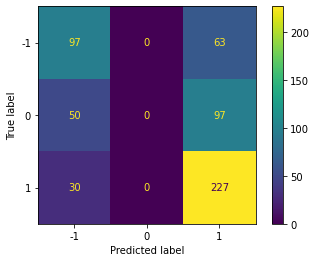

[CV] END C=2.9763514416313193, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1.438449888287663, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.16237767391887226, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.16237767391887226, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.16237767391887226, multi_class=multinomial, penalty=l2, solver=lbfgs; 

[CV] END C=2.9763514416313193, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1.438449888287663, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=1.438449888287663, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.00206913808111479, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s

[CV] END C=2.9763514416313193, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.00206913808111479, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.00206913808111479, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.00206913808111479, multi_class=ovr, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.00206913808111479, multi_class=ovr, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=233.57214690

[CV] END C=2.9763514416313193, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1.438449888287663, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=1.438449888287663, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.07847599703514622, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solv

[CV] END C=2.9763514416313193, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1.438449888287663, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.16237767391887226, multi_class=multinomial, penalty=l2, so

In [99]:
confusion_matrix(lr, skf, X_scaled, y)

### 2. Naive Bayes

In [226]:
nb = GaussianNB()

# set hyperparameter grid for optimisation
nb_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

In [227]:
nb_score = model_eval(nb, nb_grid, skf, X_scaled, y);
nb_score

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END C=0.037926901907322536, multi_class=ovr, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=0.037926901907322536, multi_class=ovr, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=0.037926901907322536, multi_class=multinomial, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.037926901907322536, multi_class=multinomial, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.037926901907322536, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.037926901907322536, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.037926901907322536, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.037926901907322536, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.037926901907322536, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.037926901907322

[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.018329807108324374, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.018329807108324374, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.018329807108324374, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.018329807108324374, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.008858667904100831, multi_class=ovr, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=0.008858667904100831, multi_class=ovr, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=0.008858667904100831, multi_class=ovr, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=0.008858667904100831, multi_class=ovr, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=1

0.5451142283311367

In [228]:
# implement tuned hyperparameters to model
nb = GaussianNB(var_smoothing=1)

              precision    recall  f1-score   support

          -1       0.55      0.60      0.57       161
           0       0.00      0.00      0.00       147
           1       0.58      0.88      0.70       256

    accuracy                           0.57       564
   macro avg       0.38      0.49      0.42       564
weighted avg       0.42      0.57      0.48       564



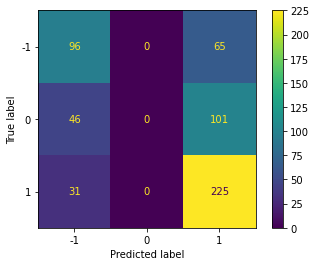

In [229]:
confusion_matrix(nb, skf, X_scaled, y)

### 3. Linear Discriminant Analysis (LDA)

In [230]:
lda = LDA()

# set hyperparameter grid for optimisation
lda_grid = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': np.linspace(0, 1, num=11),
    'tol': np.logspace(0, -4, num=20)
}

In [231]:
lda_score = model_eval(lda, lda_grid, skf, X_scaled, y);
lda_score

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END C=0.008858667904100831, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.008858667904100831, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.008858667904100831, multi_class=multinomial, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.008858667904100831, multi_class=multinomial, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=0.008858667904100831, multi_class=multinomial, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.008858667904100831, multi_class=multinomial, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.004281332398719396, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.004281332398719396, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.004281332398719396, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.004281332398719396, multi_class

[CV] END C=0.004281332398719396, multi_class=multinomial, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.004281332398719396, multi_class=multinomial, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.00206913808111479, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.00206913808111479, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.00206913808111479, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.00206913808111479, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.00206913808111479, multi_class=multinomial, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.00206913808111479, multi_class=multinomial, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.00206913808111479, multi_class=multinomial, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.00206913808111479, multi_class=multinomial, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.001, multi_class=

Cross-val accuracy: 54.564708466704325 %
tol: 0.033598182862837826
solver: eigen
shrinkage: 0.4


0.5456470846670433

In [232]:
# implement tuned hyperparameters to model
lda = LDA(solver='eigen', shrinkage=0.4, tol=0.033598182862837826)

              precision    recall  f1-score   support

          -1       0.55      0.61      0.58       161
           0       1.00      0.01      0.01       147
           1       0.58      0.87      0.70       256

    accuracy                           0.57       564
   macro avg       0.71      0.50      0.43       564
weighted avg       0.68      0.57      0.48       564



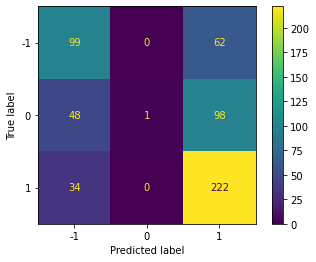

In [233]:
confusion_matrix(lda, skf, X_scaled, y)

### 4. Quadratic Discriminant Analysis (QDA)

In [234]:
qda = QDA()

# set hyperparameter grid for optimisation
qda_grid = {
    'tol': np.logspace(0, -4, num=20)
}

In [235]:
qda_score = model_eval(qda, qda_grid, skf, X_scaled, y);
qda_score

/Users/rafa/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Cross-val accuracy: 51.71082031004832 %
tol: 1.0


0.5171082031004832

In [236]:
# implement tuned hyperparameters to model
qda = QDA(tol=1)

              precision    recall  f1-score   support

          -1       0.49      0.66      0.57       161
           0       0.30      0.09      0.14       146
           1       0.63      0.74      0.68       257

    accuracy                           0.55       564
   macro avg       0.47      0.50      0.46       564
weighted avg       0.51      0.55      0.51       564



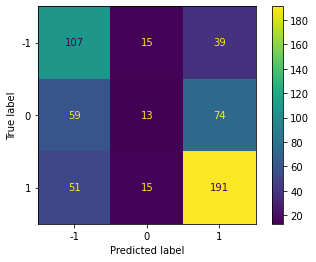

In [237]:
confusion_matrix(qda, skf, X_scaled, y)

### 5. Random Forest Classifier (RFC)

In [238]:
rfc = RandomForestClassifier()

# set hyperparameter grid for optimisation
rfc_grid = {
    'n_estimators': np.linspace(10, 50, num=11, dtype=int),
    'max_depth': np.linspace(10, 110, num = 6, dtype=int),
    'min_samples_split': np.linspace(2, 10, num = 6, dtype=int),
    'min_samples_leaf': np.linspace(1, 5, num = 6, dtype=int),
    'max_features': ['sqrt', 'log2', None]
}

In [239]:
rfc_score = model_eval(rfc, rfc_grid, skf, X_scaled, y);
rfc_score

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END C=1.438449888287663, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=1.438449888287663, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=1.438449888287663, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.004281332398719396, multi_class=ovr, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=0.004281332398719396, multi_class=ovr, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=483.2930238571752, multi_class=multinomial, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=483.2930238571752, multi_class=multinomial, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=1000.0, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1.438449888287663, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1.438449888287663, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.0s
[CV]

[CV] END ...................var_smoothing=0.0533669923120631; total time=   0.0s
[CV] END ...................var_smoothing=0.0533669923120631; total time=   0.0s
[CV] END ...................var_smoothing=0.0533669923120631; total time=   0.0s
[CV] END ..................var_smoothing=0.02310129700083159; total time=   0.0s
[CV] END ..................var_smoothing=0.02310129700083159; total time=   0.0s
[CV] END ..................var_smoothing=0.02310129700083159; total time=   0.0s
[CV] END ..................var_smoothing=0.02310129700083159; total time=   0.0s
[CV] END ..................var_smoothing=0.02310129700083159; total time=   0.0s
[CV] END ..................var_smoothing=0.02310129700083159; total time=   0.0s
[CV] END ..................var_smoothing=0.01873817422860384; total time=   0.0s
[CV] END ..................var_smoothing=0.01873817422860384; total time=   0.0s
[CV] END .................var_smoothing=0.002848035868435802; total time=   0.0s
[CV] END .................va

[CV] END ..................var_smoothing=0.08111308307896872; total time=   0.0s
[CV] END ..................var_smoothing=0.08111308307896872; total time=   0.0s
[CV] END ..................var_smoothing=0.08111308307896872; total time=   0.0s
[CV] END ..................var_smoothing=0.03511191734215131; total time=   0.0s
[CV] END ..................var_smoothing=0.03511191734215131; total time=   0.0s
[CV] END ..................var_smoothing=0.03511191734215131; total time=   0.0s
[CV] END ..................var_smoothing=0.03511191734215131; total time=   0.0s
[CV] END ..................var_smoothing=0.03511191734215131; total time=   0.0s
[CV] END ..................var_smoothing=0.03511191734215131; total time=   0.0s
[CV] END ..................var_smoothing=0.03511191734215131; total time=   0.0s
[CV] END ..................var_smoothing=0.03511191734215131; total time=   0.0s
[CV] END ..................var_smoothing=0.01519911082952933; total time=   0.0s
[CV] END ..................v

[CV] END ..................var_smoothing=0.04328761281083057; total time=   0.0s
[CV] END ..................var_smoothing=0.04328761281083057; total time=   0.0s
[CV] END ..................var_smoothing=0.04328761281083057; total time=   0.0s
[CV] END ..................var_smoothing=0.01519911082952933; total time=   0.0s
[CV] END ..................var_smoothing=0.01519911082952933; total time=   0.0s
[CV] END .................var_smoothing=0.012328467394420659; total time=   0.0s
[CV] END .................var_smoothing=0.012328467394420659; total time=   0.0s
[CV] END .................var_smoothing=0.012328467394420659; total time=   0.0s
[CV] END .................var_smoothing=0.012328467394420659; total time=   0.0s
[CV] END .................var_smoothing=0.012328467394420659; total time=   0.0s
[CV] END .................var_smoothing=0.012328467394420659; total time=   0.0s
[CV] END .................var_smoothing=0.005336699231206307; total time=   0.0s
[CV] END .................va

[CV] END C=6.158482110660267, multi_class=ovr, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=6.158482110660267, multi_class=ovr, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=6.158482110660267, multi_class=ovr, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=1000.0, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=1000.0, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=1000.0, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1.438449888287663, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1.438449888287663, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1.438449888287663, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=26.366508987303583, multi_class=ovr, penalty=l2, solver=saga; total time=   0.1s
[CV] END .................var_smoothing=0.006579332246575682; total time=   0.0s
[CV] END ..

[CV] END ..................var_smoothing=0.02848035868435802; total time=   0.0s
[CV] END ..................var_smoothing=0.02848035868435802; total time=   0.0s
[CV] END ..................var_smoothing=0.02848035868435802; total time=   0.0s
[CV] END .................var_smoothing=0.012328467394420659; total time=   0.0s
[CV] END .................var_smoothing=0.012328467394420659; total time=   0.0s
[CV] END .................var_smoothing=0.012328467394420659; total time=   0.0s
[CV] END .................var_smoothing=0.012328467394420659; total time=   0.0s
[CV] END .................................var_smoothing=0.01; total time=   0.0s
[CV] END .................................var_smoothing=0.01; total time=   0.0s
[CV] END .................................var_smoothing=0.01; total time=   0.0s
[CV] END .................................var_smoothing=0.01; total time=   0.0s
[CV] END .................var_smoothing=0.003511191734215131; total time=   0.0s
[CV] END .................va

[CV] END ...............................var_smoothing=0.0001; total time=   0.0s
[CV] END ................var_smoothing=2.848035868435799e-07; total time=   0.0s
[CV] END ................var_smoothing=2.848035868435799e-07; total time=   0.0s
[CV] END ................var_smoothing=2.848035868435799e-07; total time=   0.0s
[CV] END ................var_smoothing=2.848035868435799e-07; total time=   0.0s
[CV] END ................var_smoothing=2.848035868435799e-07; total time=   0.0s
[CV] END ................var_smoothing=2.848035868435799e-07; total time=   0.0s
[CV] END ................var_smoothing=2.848035868435799e-07; total time=   0.0s
[CV] END ................var_smoothing=2.848035868435799e-07; total time=   0.0s
[CV] END ................var_smoothing=2.848035868435799e-07; total time=   0.0s
[CV] END ................var_smoothing=2.848035868435799e-07; total time=   0.0s
[CV] END ................var_smoothing=2.310129700083158e-07; total time=   0.0s
[CV] END ................var

Cross-val accuracy: 53.270539132617834 %
n_estimators: 30
min_samples_split: 10
min_samples_leaf: 2
max_features: sqrt
max_depth: 10


0.5327053913261783

In [240]:
# implement tuned hyperparameters to model
rfc = RandomForestClassifier(n_estimators=30, min_samples_split=10, min_samples_leaf=2, max_features='sqrt', max_depth=10)

              precision    recall  f1-score   support

          -1       0.53      0.58      0.55       161
           0       0.26      0.05      0.09       146
           1       0.59      0.81      0.68       257

    accuracy                           0.55       564
   macro avg       0.46      0.48      0.44       564
weighted avg       0.48      0.55      0.49       564



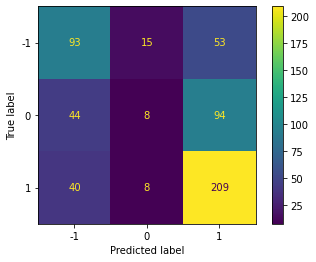

In [241]:
confusion_matrix(rfc, skf, X_scaled, y)

### 6. Support Vector Classifier (SVC)

In [304]:
svc = SVC()

# set hyperparameter grid for optimisation
svc_grid = {
    'C': np.logspace(3, -3, num=10),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': np.linspace(1, 10, num=11)
}

In [305]:
svc_score = model_eval(svc, svc_grid, 3, X_scaled, y);
svc_score

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

In [240]:
# implement tuned hyperparameters to model
svc = RandomForestClassifier(n_estimators=30, min_samples_split=10, min_samples_leaf=2, max_features='sqrt', max_depth=10)

              precision    recall  f1-score   support

          -1       0.53      0.58      0.55       161
           0       0.26      0.05      0.09       146
           1       0.59      0.81      0.68       257

    accuracy                           0.55       564
   macro avg       0.46      0.48      0.44       564
weighted avg       0.48      0.55      0.49       564



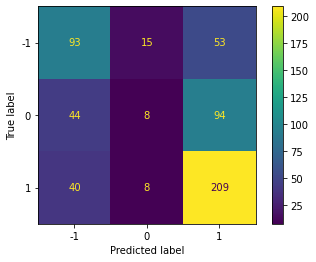

In [241]:
confusion_matrix(svc, skf, X_scaled, y)

              precision    recall  f1-score   support

          -1       0.50      0.53      0.52       321
           0       0.00      0.00      0.00       321
           1       0.53      0.86      0.65       487

    accuracy                           0.52      1129
   macro avg       0.34      0.46      0.39      1129
weighted avg       0.37      0.52      0.43      1129



/Users/rafa/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rafa/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rafa/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


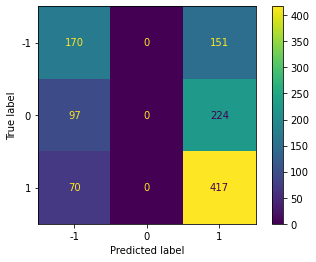

In [50]:
svc = SVC(kernel='rbf', random_state=random_state)
svc.fit(X_train, y_train)
y_svc = svc.predict(X_val)

print(classification_report(y_val,y_svc))
ConfusionMatrixDisplay.from_predictions(y_val,y_svc);

### 7. Decision Tree Classifier

In [253]:
dtc = DecisionTreeClassifier()

# set hyperparameter grid for optimisation
dtc_grid = {
    'max_depth': np.linspace(10, 110, num = 6, dtype=int),
    'min_samples_split': np.linspace(2, 10, num = 6, dtype=int),
    'min_samples_leaf': np.linspace(1, 5, num = 6, dtype=int),
    'max_features': ['sqrt', 'log2', None]
}

In [254]:
dtc_score = model_eval(dtc, dtc_grid, skf, X_scaled, y);
dtc_score

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Cross-val accuracy: 48.87350153768907 %
min_samples_split: 8
min_samples_leaf: 2
max_features: sqrt
max_depth: 10


0.48873501537689074

In [255]:
# implement tuned hyperparameters to model
dtc = DecisionTreeClassifier(min_samples_split=8, min_samples_leaf=2, max_features='sqrt', max_depth=10)

              precision    recall  f1-score   support

          -1       0.43      0.44      0.44       160
           0       0.36      0.24      0.29       147
           1       0.55      0.64      0.59       257

    accuracy                           0.48       564
   macro avg       0.45      0.44      0.44       564
weighted avg       0.47      0.48      0.47       564



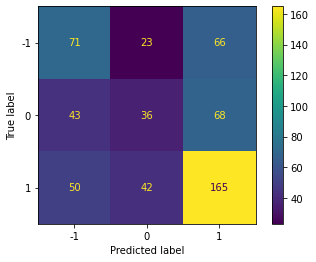

In [256]:
confusion_matrix(dtc, skf, X_scaled, y)

### 8. Adaptive Boosting Classifier

In [281]:
ada = AdaBoostClassifier()

# set hyperparameter grid for optimisation
ada_grid = {
    'base_estimator': [dtc, lr],
    'n_estimators': np.linspace(50, 100, num=11, dtype=int),
    'learning_rate': np.linspace(0.1, 2, num=20, dtype=float),
    'algorithm': ['SAMME']
}

In [282]:
ada_score = model_eval(ada, ada_grid, skf, X_scaled, y);
ada_score

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Cross-val accuracy: 54.47589907738657 %
n_estimators: 60
learning_rate: 1.8
base_estimator: LogisticRegression(C=0.037926901907322536, max_iter=1000, multi_class='ovr',
                   random_state=RandomState(MT19937) at 0x7FE2308EFE40)
algorithm: SAMME


0.5447589907738657

In [283]:
# implement tuned hyperparameters to model
ada = AdaBoostClassifier(base_estimator=lr, n_estimators=60, learning_rate=1.8, algorithm='SAMME')

              precision    recall  f1-score   support

          -1       0.53      0.61      0.57       160
           0       0.00      0.00      0.00       147
           1       0.59      0.87      0.70       257

    accuracy                           0.57       564
   macro avg       0.37      0.49      0.42       564
weighted avg       0.42      0.57      0.48       564



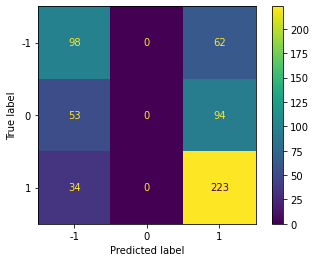

In [284]:
confusion_matrix(ada, skf, X_scaled, y)

### 9. Multi-Layer Perceptron (MLP)

In [294]:
mlp = MLPClassifier(max_iter=2000)

# set hyperparameter grid for optimisation
mlp_grid = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': np.logspace(1, -4, num=10),
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'hidden_layer_sizes': [(1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(11,), (12,),(13,),(14,),(15,),(16,),(17,),(18,),(19,),(20,),(21,)]
}

In [295]:
mlp_score = model_eval(mlp, mlp_grid, skf, X_scaled, y);
mlp_score

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Cross-val accuracy: 54.49372371806942 %
solver: adam
learning_rate: constant
hidden_layer_sizes: (7,)
alpha: 0.016681005372000592
activation: identity


0.5449372371806942

In [296]:
# implement tuned hyperparameters to model
mlp = MLPClassifier(max_iter=2000, solver='adam', learning_rate='constant', hidden_layer_sizes=(7,), alpha=0.016681005372000592, activation='identity')

              precision    recall  f1-score   support

          -1       0.53      0.61      0.57       160
           0       0.00      0.00      0.00       147
           1       0.59      0.87      0.70       257

    accuracy                           0.57       564
   macro avg       0.37      0.49      0.42       564
weighted avg       0.42      0.57      0.48       564



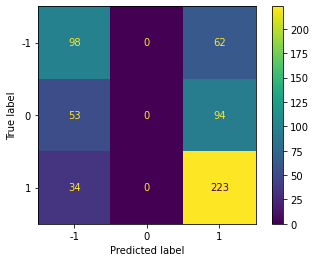

In [297]:
confusion_matrix(ada, skf, X_scaled, y)

### Comparing model performance

,LR,NB,LDA,QDA,RFC,SVC,DTC,ADA,MLP
0,0.544937,0.545114,0.545647,0.517108,0.532705,0.5,0.488735,0.544759,0.544937


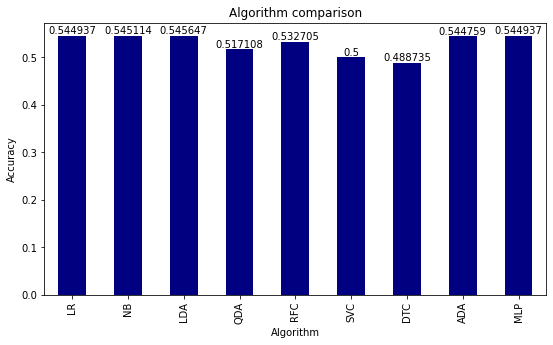

In [301]:
# create a dictionary variable with keys being algorithms names and values being classification predictions
results = { 
    'LR': lr_score,
    'NB': nb_score,
    'LDA': lda_score,
    'QDA': qda_score,
    'RFC': rfc_score,
    'SVC': svc_score,
    'DTC': dtc_score,
    'ADA': ada_score,
    'MLP': mlp_score
}
    
results = pd.DataFrame(data=results, index=[0])
ax = results.T.plot.bar(
    title='Algorithm comparison',
    xlabel='Algorithm',
    ylabel='Accuracy',
    color='navy',
    figsize=(9, 5),
    legend=False,
)
ax.bar_label(ax.containers[0])

results

# Part 4 - Testing

[CHANGE]

In [100]:
# scale data
X_test = scaler.transform(test_data)

In [101]:
y_test = lr.predict(X_test)

              precision    recall  f1-score   support

          -1       0.46      0.49      0.48        65
           0       0.00      0.00      0.00        64
           1       0.58      0.87      0.70       118

    accuracy                           0.55       247
   macro avg       0.35      0.46      0.39       247
weighted avg       0.40      0.55      0.46       247



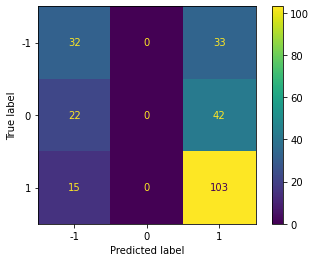

[CV] END C=2.9763514416313193, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=1.438449888287663, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.16237767391887226, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.16237767391887226, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.00206913808111479, multi_class=ovr, penalty=l2, solver=sag; total 

[CV] END C=2.9763514416313193, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.16237767391887226, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.16237767391887226, multi_class=multinomial, penalty=l2, solver=lbf

[CV] END C=2.9763514416313193, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1.438449888287663, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.00206913808111479, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.00206913808111479, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s

[CV] END C=2.9763514416313193, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1.438449888287663, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=1.438449888287663, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.008858667904100831, multi_class=ovr, penalty=l2, solver=sag; tot

[CV] END C=2.9763514416313193, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=2.9763514416313193, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1.438449888287663, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=ovr, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.07847599703514622, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.33598182862837844, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.16237767391887226, multi_class=multinomial, penalty=l2, solver=lbfgs; tot

In [102]:
print(classification_report(y_test_actual, y_test, zero_division=0))
ConfusionMatrixDisplay.from_predictions(y_test_actual, y_test);

### ROC Curve
A Receiver Operating Characteristic curve (ROC curve) is a graphical plot of the true positive rate (TPR) against the false positive rate (FPR), using different threshold settings:

In [ ]:
# binarise output
y_train_bin = label_binarize(y_train, classes=[-1, 0, 1])
y_val_bin = label_binarize(y_val, classes=[-1, 0, 1])

# learn to predict each class against the other, using MLP which was the most accurate model
classifier = OneVsRestClassifier(MLPClassifier(alpha=15, max_iter=1000000))
y_score = classifier.fit(X_train, y_train_bin).predict_proba(X_val)

# compute ROC curve and area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in [-1, 0, 1]:
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

We now proceed to compute and plot the micro and macro averages.

In [ ]:
# aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in [-1, 0, 1]]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in [-1, 0, 1]:
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 3

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# plotting results   
plt.figure()

# curves for each class
plt.plot(
    fpr[-1],
    tpr[-1],
    color='tomato',
    label='ROC curve of class {0} (area = {1:0.2f})'.format(-1, roc_auc[-1]),
)
plt.plot(
    fpr[0],
    tpr[0],
    color='royalblue',
    label='ROC curve of class {0} (area = {1:0.2f})'.format(0, roc_auc[0]),
)
plt.plot(
    fpr[1],
    tpr[1],
    color='forestgreen',
    label='ROC curve of class {0} (area = {1:0.2f})'.format(1, roc_auc[1]),
)

# curves for micro and macro averages
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="slategrey",
    linestyle="--",
)
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="darkorchid",
    linestyle="--",
)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

# Part 5 - Prediction

[CHANGE]

In [192]:
# scale data
X_pred = scaler.transform(pred_data)

In [193]:
y_pred_outcome = lr.predict(X_pred)
y_pred_proba = lr.predict_proba(X_pred)

In [194]:
# we now take a look at the match probabilities and output
pred_output = pred_output.assign(home_team_result=y_pred_outcome)
pred_output['home_team_result'] = pred_output['home_team_result'].map({1:'Win', 0:'Draw', -1:'Lose'})

pred_output = pred_output.assign(win_probability=[i[2] for i in y_pred_proba])
pred_output = pred_output.assign(draw_probability=[i[1] for i in y_pred_proba])
pred_output = pred_output.assign(lose_probability=[i[0] for i in y_pred_proba])

pred_output

,date,home_team,away_team,home_team_result,win_probability,draw_probability,lose_probability
0,2022-11-20,Qatar,Ecuador,Lose,0.000454,0.357482,0.642063
1,2022-11-21,Senegal,Netherlands,Lose,0.234081,0.295409,0.470509
2,2022-11-21,England,IR Iran,Win,0.667042,0.245086,0.087872
3,2022-11-21,USA,Wales,Win,0.381562,0.314420,0.304017
4,2022-11-22,France,Australia,Win,0.686908,0.226709,0.086383
5,2022-11-22,Denmark,Tunisia,Win,0.560995,0.253811,0.185194
6,2022-11-22,Mexico,Poland,Lose,0.361412,0.267543,0.371045
7,2022-11-22,Argentina,Saudi Arabia,Win,0.716170,0.224483,0.059347
8,2022-11-23,Belgium,Canada,Win,0.671180,0.219197,0.109623
9,2022-11-23,Spain,Costa Rica,Win,0.711367,0.193674,0.094958


# [END PROJECT]